In [1]:
# PCA
#from sklearn.decomposition import PCA

# other
import torch
import numpy as np
import random
from scipy.linalg import orth
import matplotlib.pyplot as plt
import pickle

# Device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
dtype = torch.cuda.FloatTensor

In [2]:
load_data = False
save_data = True
run_simulation = True

## Data model

In [3]:
class dataGen():
    
    def __init__(self,n,d,seed=10):
        # n: ambient dimension
        # d: signal dimension
        
        # Seeding
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        # subspace model
        self.U = torch.from_numpy( orth(np.random.normal(loc=0, scale=1, size=[n,d])) )
        
        self.trY_prime_list = []
        
    def create_train_data(self, n, d, N, sigma_e=0.1, sigma_e_prime_list=[0.1]):
        # n: ambient dimension
        # d: signal dimension
        # N: number of training samples
        # sigma_e: noise standard deviation of the input data. This is the noise level we aim to denoise
        # sigma_e_prime: list of different noise standard deviations of the target data during training noise2noise
        
        # train data
        self.C = torch.from_numpy( np.random.normal(loc=0, scale=1.0/np.sqrt(d), size=[d,N]) )
        self.e = torch.from_numpy( np.random.normal(loc=0, scale=sigma_e/np.sqrt(n), size=[n,N]) )
        self.trX = self.U @ self.C
        
        self.trY = self.trX + self.e
        
        # Generate target train data with different noise levels
        for sigma_e_prime in sigma_e_prime_list:
            e_prime = torch.from_numpy( np.random.normal(loc=0, scale=sigma_e_prime/np.sqrt(n), size=[n,N]) )
            self.trY_prime_list.append(self.trX + e_prime)

## Estimators

### The estimator learned with gradient descent in the limit of infinite many iterations

In [4]:
class gradient_descent_converged():
    '''
    The estimator learned with gradient descent if we let the number of iterations go to infinity.
    '''    
    def test_risk(self, U, sigma_e):
        '''
        Compute the risk for a given estimator W subspace U and noise statistics sigma_e.
        '''
        n = U.shape[0]
        d = U.shape[1]
        risk = np.linalg.norm( (self.W - np.eye(n)) @ U ,'fro')**2 / d + sigma_e**2 / n * np.linalg.norm(self.W,'fro')**2
        return risk
    
    def compute_GDconv_estimate(self, trX, trY, U, sigma_e):
        '''
        Compute the estimator from training data and return its risk.
        '''
        self.W = trX @ np.linalg.pinv(trY)
        
        teL = self.test_risk(U, sigma_e)
        return teL.item()

### The estimator learned with gradient descent

In [5]:
class GD_model():
    '''
    Learn an estimator bwith gradient descent form the data X,Y
    '''
    def __init__(self, n):
        self.n = n
        self.W = torch.zeros([n,n]).type(dtype)
    
    def test_risk(self, U, sigma_e):
        '''
        Compute the risk for a given estimator W subspace U and noise statistics sigma_e.
        '''
        n = U.shape[0]
        d = U.shape[1]
        risk = torch.linalg.norm( (self.W - torch.eye(n).type(dtype)) @ U ,'fro')**2 /d + sigma_e**2 / n * torch.linalg.norm(self.W,'fro')**2
        return risk
    
    def train(self, trX, trY, U, sigma_e, num_iters=1000, lr = 1e-2):
        trainL_emp = []
        testL = []

        N = trX.shape[-1]
        d = U.shape[1]
        early_stopping_counter = 0
        early_stopping_loss = 10000
        for i in range(num_iters):
            if i % 100 == 0:
                print('Iteration : {}/{}'.format(i,num_iters))
            ### train
            # compute the gradient
            dW = self.W @ trY @ trY.T - trX @ trY.T
            
            # update the weights
            self.W -= lr*dW
            
            # train loss
            Xhat = self.W @ trY
            trl =  ( (Xhat-trX)**2 ).sum()/(N*d)
            trainL_emp.append(trl.item())
            
            ### test
            tel = self.test_risk(U, sigma_e)
            testL.append(tel.item())
            
            # Stop if train loss is not improving anymore
            if i>100 and np.abs(trainL_emp[-1]-trainL_emp[-2]) < 1e-20:
                print('Stopped at iteration {} due to convergence'.format(i))
                break
            
            
            # Early stopp 1000 iterations after the test loss reached its minimum
            if testL[-1] < early_stopping_loss:
                early_stopping_loss = testL[-1]
            else:
                early_stopping_counter += 1
            if early_stopping_counter == 1000:
                print('Stopped at iteration {} due to early stopping'.format(i))
                break
            
        return testL, trainL_emp

### Risk minimizing optimal solution

In [6]:
class optimal_estimator():
    '''
    This method assumes knowledge of the subspace U.
    '''     
    def risk_emp(self, X, Xhat, d):       
        '''
        Compute the risk empirical based on the test set or the training set.
        '''
        r = ( (Xhat-X)**2 ).sum()/(X.shape[1]) #divide by N*d
        return r
    
    def test_risk(self, U, sigma_e):
        '''
        Compute the risk for a given estimator W subspace U and noise statistics sigma_e.
        '''
        n = U.shape[0]
        d = U.shape[1]
        risk = np.linalg.norm( (self.W - np.eye(n)) @ U ,'fro')**2 / d + sigma_e**2 / n * np.linalg.norm(self.W,'fro')**2
        return risk
        
    def compute_optimal_estimator(self, U, sigma_e):
        '''
        Compute the estimator from the known subspace and return its risk.
        '''
        n = U.shape[0]
        d = U.shape[1]
        self.W = 1/(1+sigma_e**2 * d / n)* U @ U.T 
        
        teL = self.test_risk(U, sigma_e)
        return teL.item()

## Simulations

**********run 0**********
*****training size (N) = 1*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.90726675
22.507081562448075
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Stopped at iteration 651 due to convergence
Gradient descent: test risk last: 0.9072668; test risk early stopped: 0.90633827; train loss: 1.0725303295228833e-13


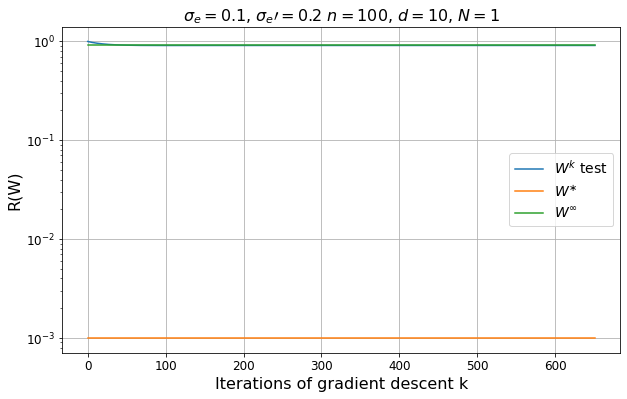

Converged gradient descent: test risk: 0.90213639
22.507081562448075
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Stopped at iteration 631 due to convergence
Gradient descent: test risk last: 0.90213639; test risk early stopped: 0.90213084; train loss: 1.0558381561632038e-13


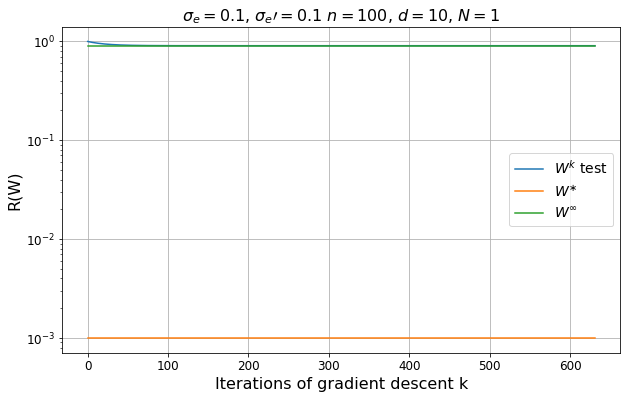

Converged gradient descent: test risk: 0.90062099
22.507081562448075
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Stopped at iteration 639 due to convergence
Gradient descent: test risk last: 0.90062094; test risk early stopped: 0.90062094; train loss: 9.49713872540163e-14


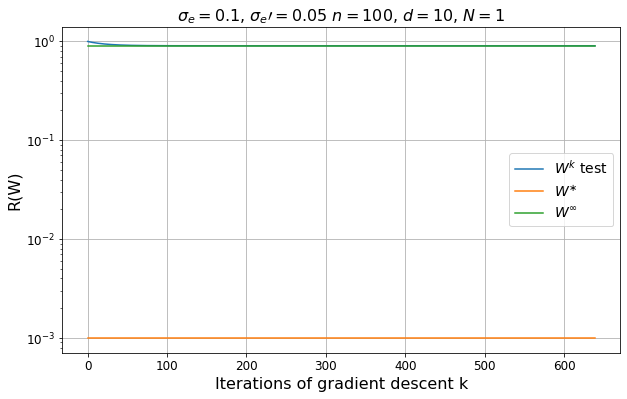

Converged gradient descent: test risk: 0.90018099
22.507081562448075
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Stopped at iteration 647 due to convergence
Gradient descent: test risk last: 0.90018106; test risk early stopped: 0.90018106; train loss: 9.603392571184283e-14


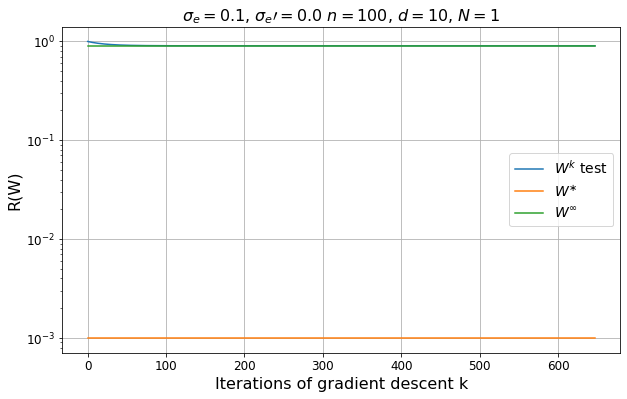



*****training size (N) = 2*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.81883218
15.914909997525749
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Stopped at iteration 1262 due to early stopping
Gradient descent: test risk last: 0.81882852; test risk early stopped: 0.8162235; train loss: 1.6687928816594422e-10


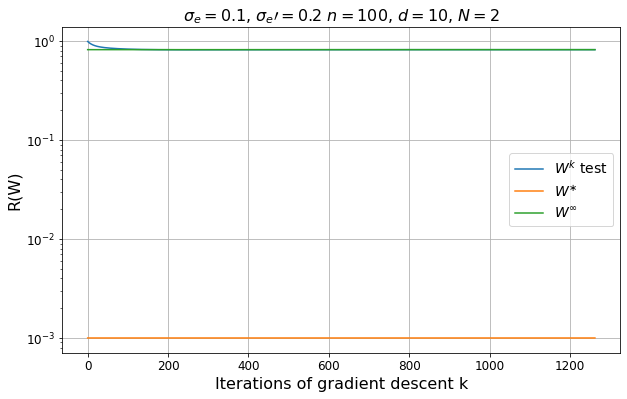

Converged gradient descent: test risk: 0.80506715
15.914909997525749
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Stopped at iteration 1780 due to early stopping
Gradient descent: test risk last: 0.80506724; test risk early stopped: 0.80506706; train loss: 2.7010219148110304e-13


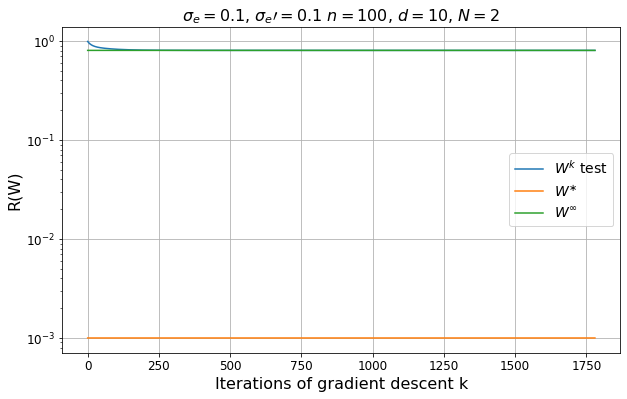

Converged gradient descent: test risk: 0.80191519
15.914909997525749
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Stopped at iteration 1912 due to early stopping
Gradient descent: test risk last: 0.80191529; test risk early stopped: 0.80191529; train loss: 2.3549489181623473e-13


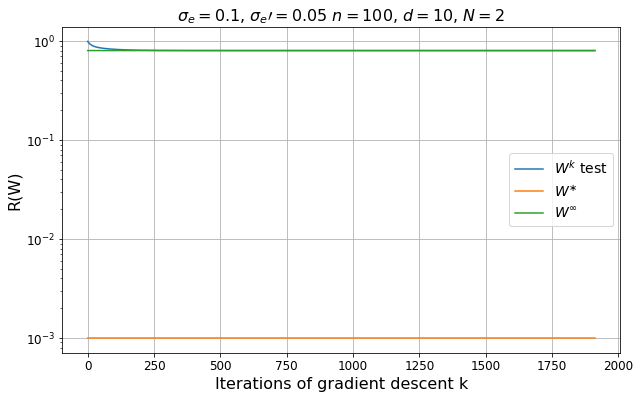

Converged gradient descent: test risk: 0.80079999
15.914909997525749
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Stopped at iteration 1955 due to early stopping
Gradient descent: test risk last: 0.80080009; test risk early stopped: 0.80079997; train loss: 2.299105730015766e-13


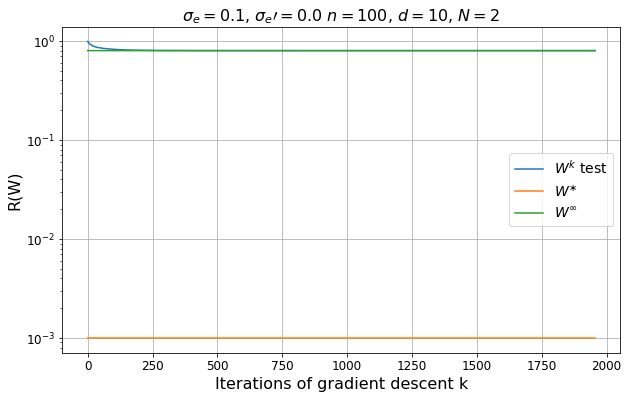



*****training size (N) = 4*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.65108907
11.253540781224038
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Stopped at iteration 1724 due to early stopping
Gradient descent: test risk last: 0.64859807; test risk early stopped: 0.64242095; train loss: 5.315994258126011e-06


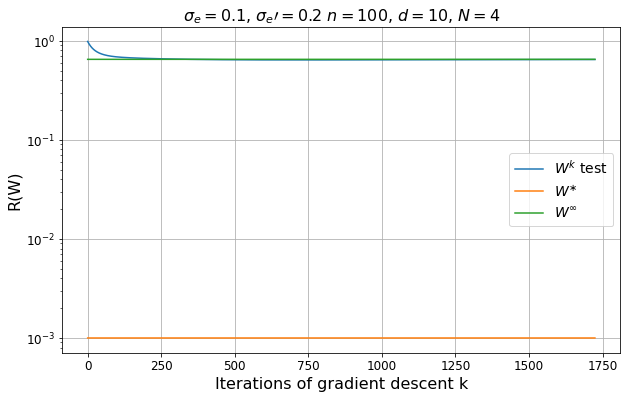

Converged gradient descent: test risk: 0.61466042
11.253540781224038
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Stopped at iteration 2544 due to early stopping
Gradient descent: test risk last: 0.61457431; test risk early stopped: 0.61437297; train loss: 1.9315234567329753e-07


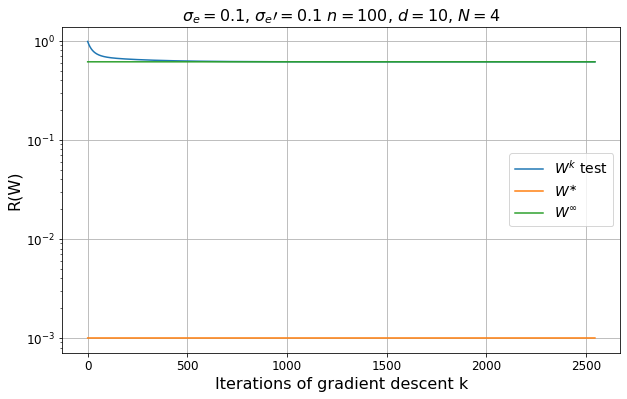

Converged gradient descent: test risk: 0.60654562
11.253540781224038
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000


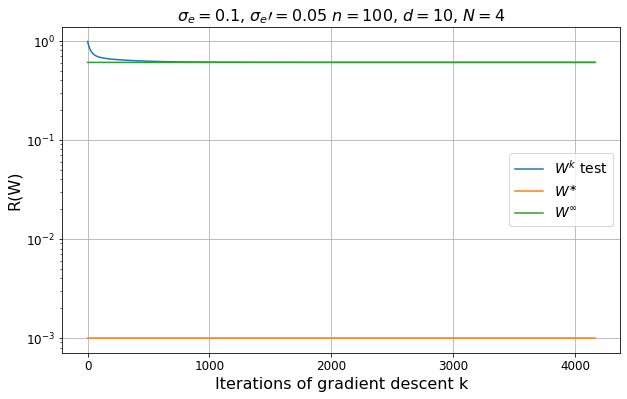

Converged gradient descent: test risk: 0.60300575
11.253540781224038
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000


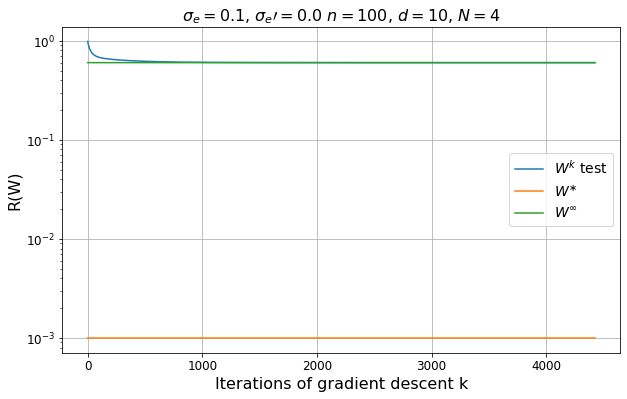



*****training size (N) = 8*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.28417553
7.957454998762874
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Stopped at iteration 2243 due to early stopping
Gradient descent: test risk last: 0.27957374; test risk early stopped: 0.27621591; train loss: 1.1617747986747418e-05


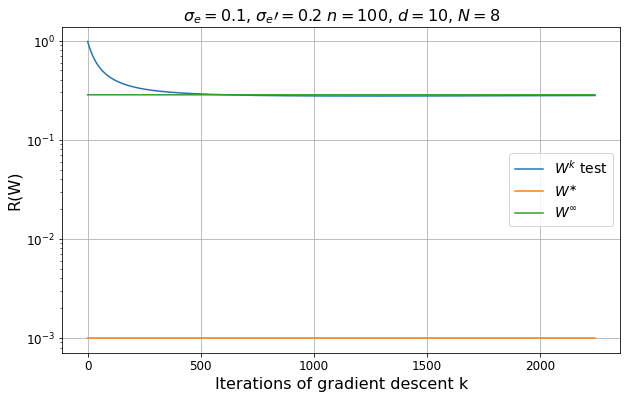

Converged gradient descent: test risk: 0.22398028
7.957454998762874
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

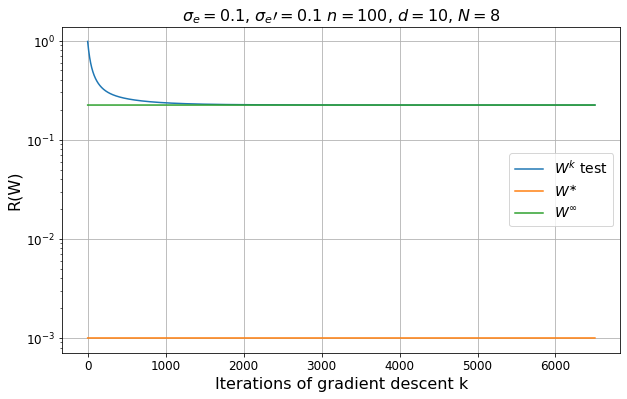

Converged gradient descent: test risk: 0.21137896
7.957454998762874
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

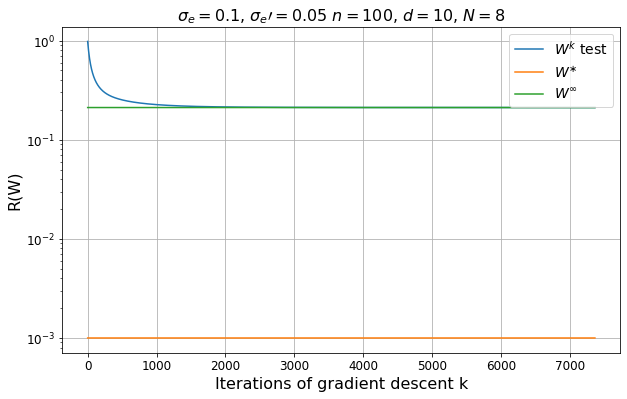

Converged gradient descent: test risk: 0.20532119
7.957454998762874
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

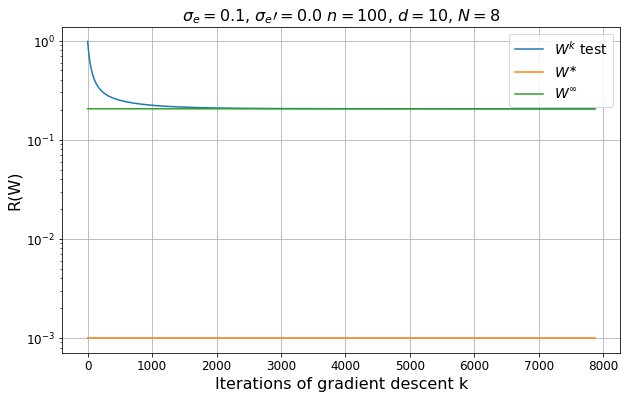



*****training size (N) = 10*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.29399417
7.117364122051717
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Stopped at iteration 2633 due to early stopping
Gradient descent: test risk last: 0.22602725; test risk early stopped: 0.22064327; train loss: 0.0003052207757718861


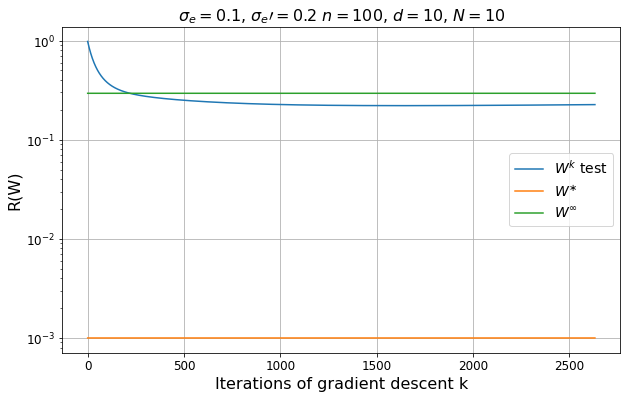

Converged gradient descent: test risk: 0.16283717
7.117364122051717
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

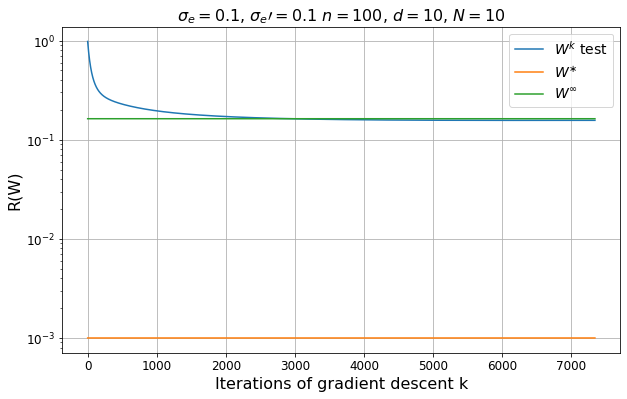

Converged gradient descent: test risk: 0.11824837
7.117364122051717
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

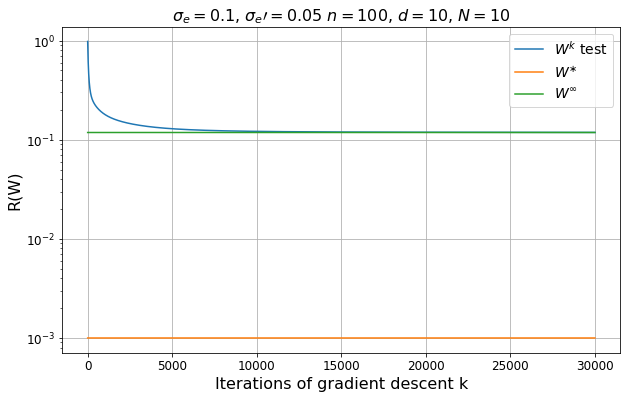

Converged gradient descent: test risk: 0.10521968
7.117364122051717
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

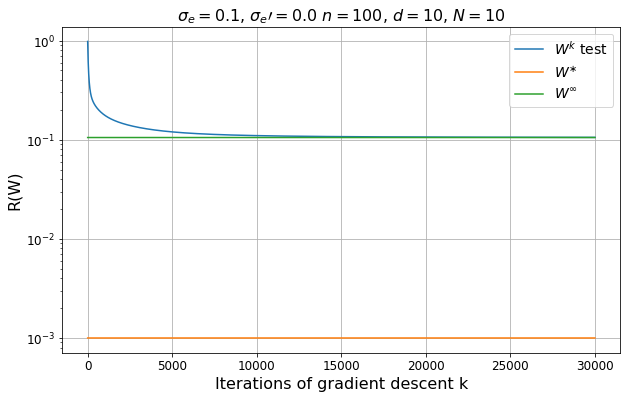



*****training size (N) = 12*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.1997719
6.4972347993761295
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Stopped at iteration 2583 due to early stopping
Gradient descent: test risk last: 0.15822124; test risk early stopped: 0.15720224; train loss: 0.0005748052499257028


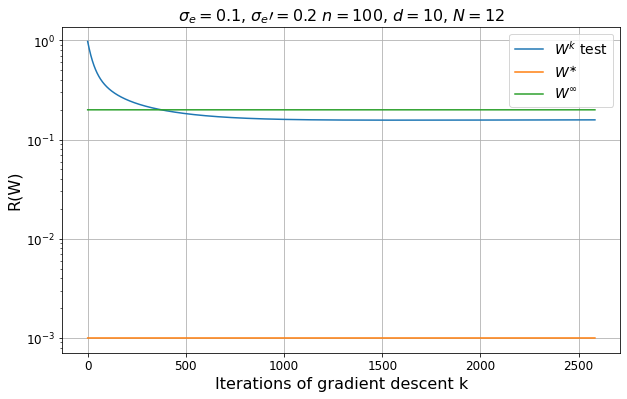

Converged gradient descent: test risk: 0.08978395
6.4972347993761295
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000


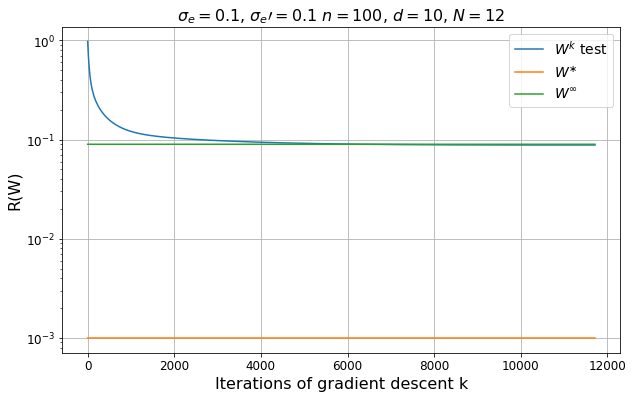

Converged gradient descent: test risk: 0.05368337
6.4972347993761295
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000


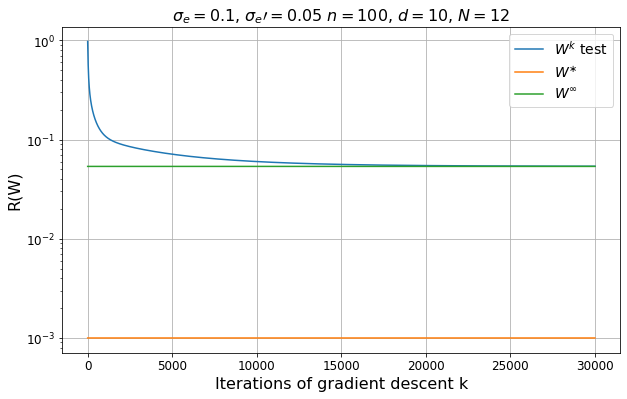

Converged gradient descent: test risk: 0.03957856
6.4972347993761295
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000


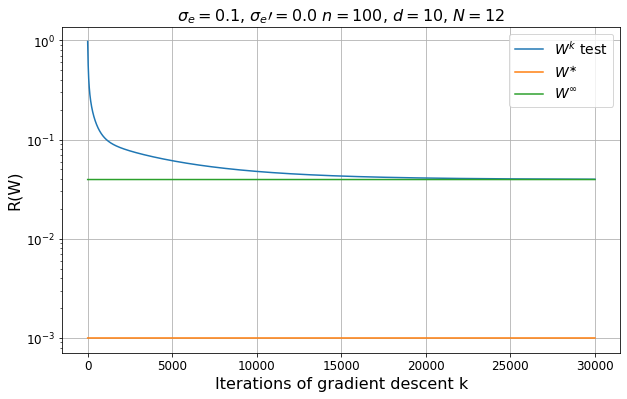



*****training size (N) = 14*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.12798503
6.015270570204102
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Stopped at iteration 2771 due to early stopping
Gradient descent: test risk last: 0.10819583; test risk early stopped: 0.10465336; train loss: 0.000747394806239754


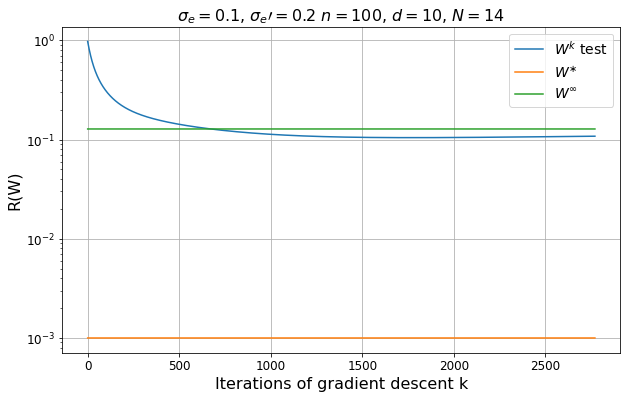

Converged gradient descent: test risk: 0.04560968
6.015270570204102
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

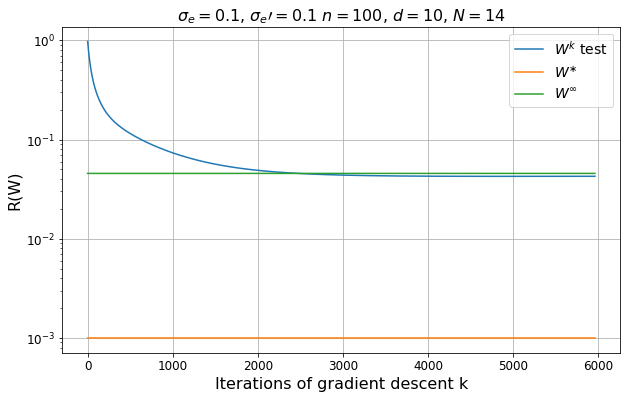

Converged gradient descent: test risk: 0.01769875
6.015270570204102
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

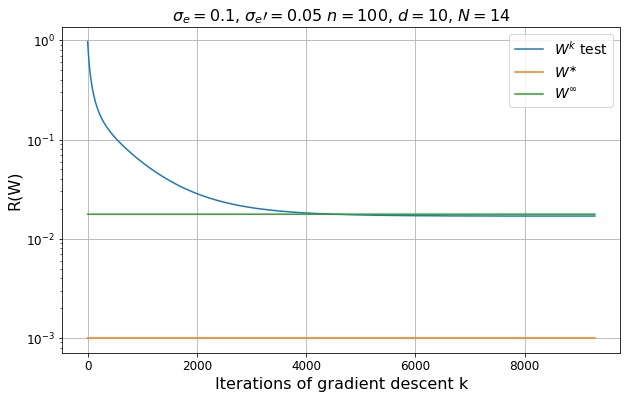

Converged gradient descent: test risk: 0.00935591
6.015270570204102
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

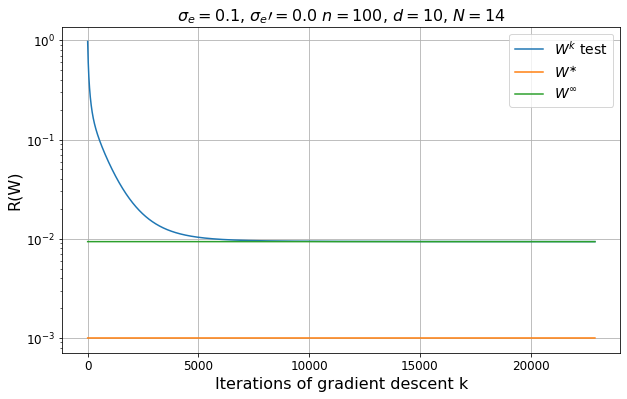



*****training size (N) = 16*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.09118261
5.626770390612019
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Stopped at iteration 2292 due to early stopping
Gradient descent: test risk last: 0.08117092; test risk early stopped: 0.07884943; train loss: 0.0011417330242693424


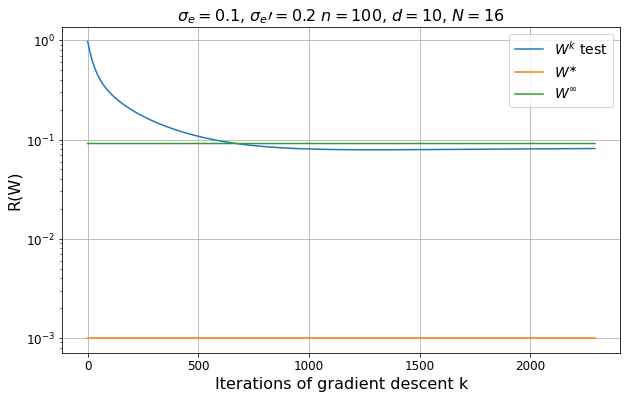

Converged gradient descent: test risk: 0.02743457
5.626770390612019
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
S

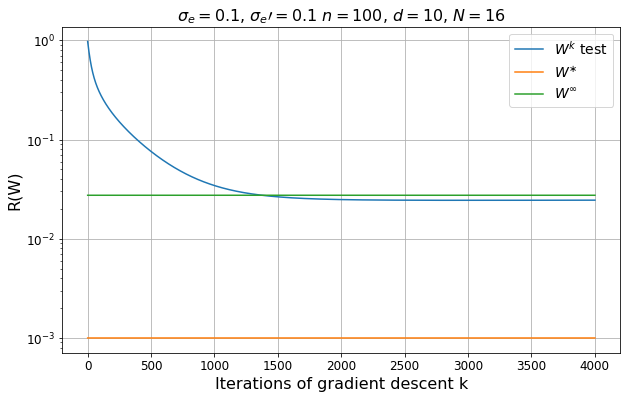

Converged gradient descent: test risk: 0.01090455
5.626770390612019
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

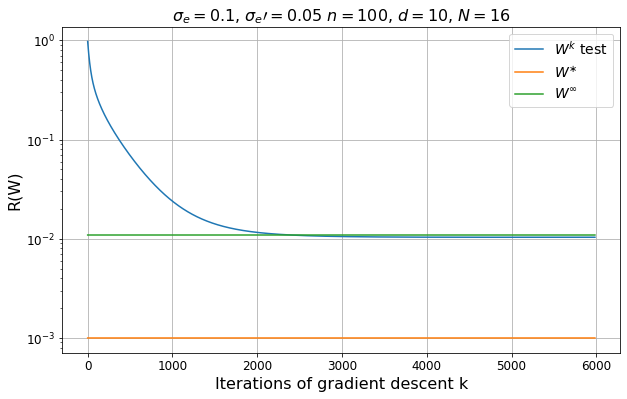

Converged gradient descent: test risk: 0.00451736
5.626770390612019
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

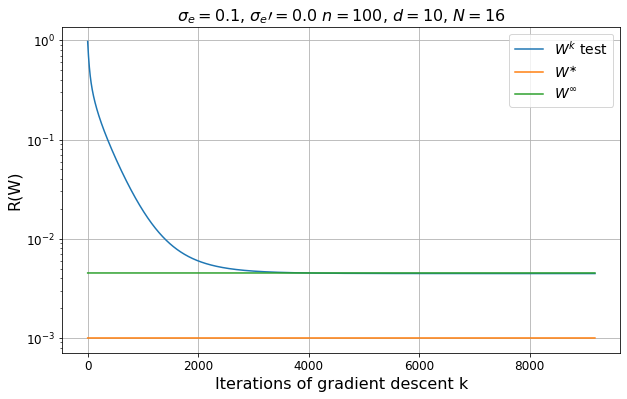



*****training size (N) = 18*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.06020781
5.30496999917525
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Stopped at iteration 1732 due to early stopping
Gradient descent: test risk last: 0.05337722; test risk early stopped: 0.05166465; train loss: 0.0013827818911522627


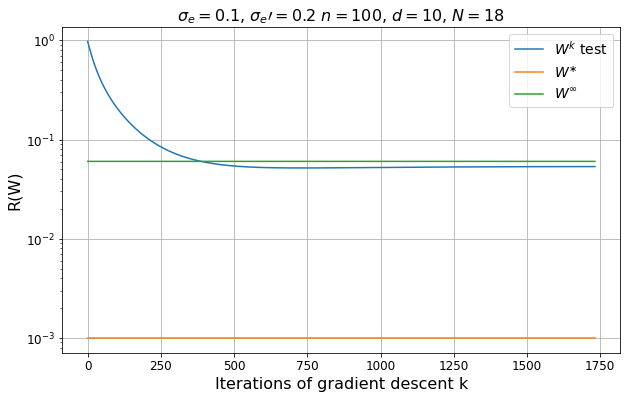

Converged gradient descent: test risk: 0.01586763
5.30496999917525
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Stopped at iteration 3008 due to early stopping
Gradient descent: test risk last: 0.01405086; test risk early stopped: 0.01403571; train loss: 0.0003103596973232925


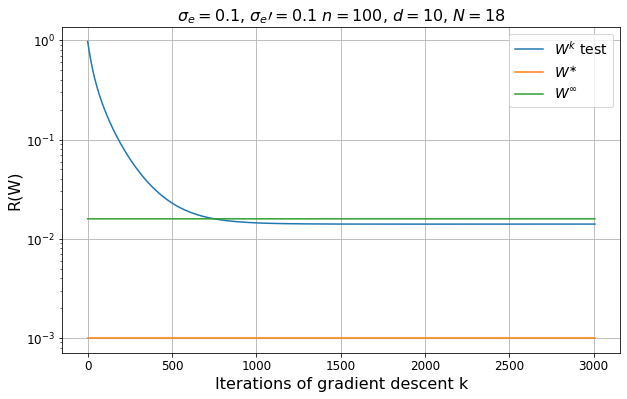

Converged gradient descent: test risk: 0.0067474
5.30496999917525
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Stopped at iteration 3192 due to early stopping
Gradient descent: test risk last: 0.00598163; test risk early stopped: 0.00596678; train loss: 8.981022983789444e-05


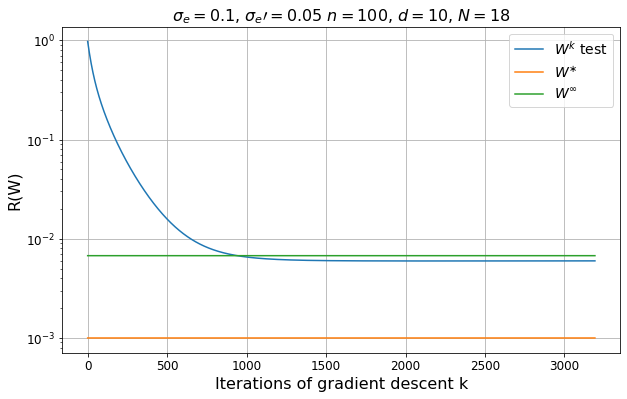

Converged gradient descent: test risk: 0.00337054
5.30496999917525
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Stopped at iteration 3739 due to early stopping
Gradient descent: test 

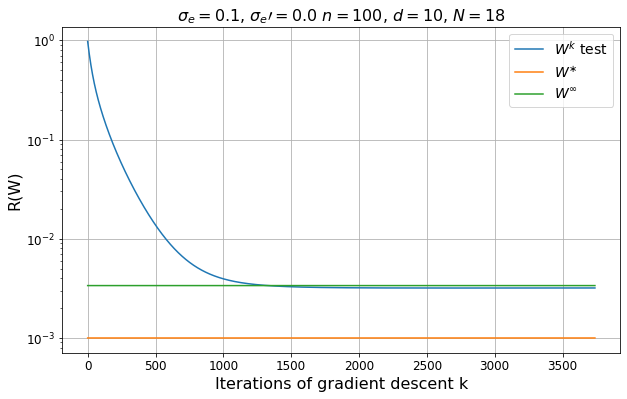



*****training size (N) = 22*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.04587971
4.798525912188081
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Stopped at iteration 1722 due to early stopping
Gradient descent: test risk last: 0.03394155; test risk early stopped: 0.03307964; train loss: 0.0017597529804334044


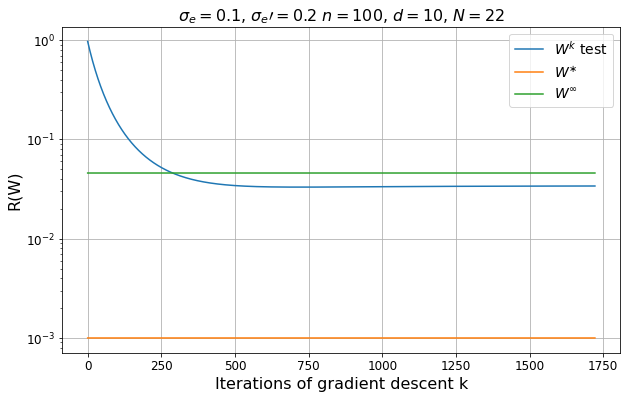

Converged gradient descent: test risk: 0.01281082
4.798525912188081
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Stopped at iteration 2349 due to early stopping
Gradient descent: test risk last: 0.00931435; test risk early stopped: 0.00927671; train loss: 0.00045803620014339685


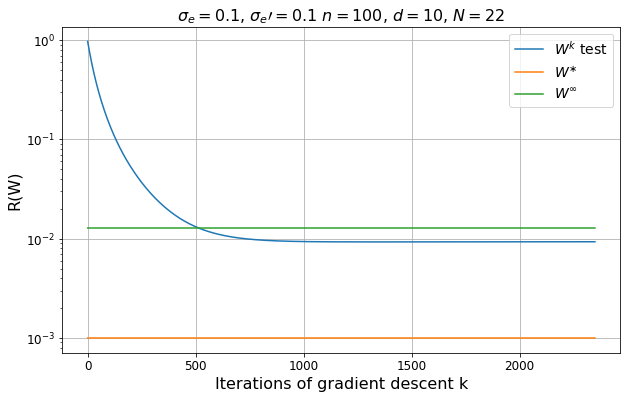

Converged gradient descent: test risk: 0.00460806
4.798525912188081
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Stopped at iteration 3027 due to early stopping
Gradient descent: test risk last: 0.00364663; test risk early stopped: 0.00363739; train loss: 0.00013091678556520492


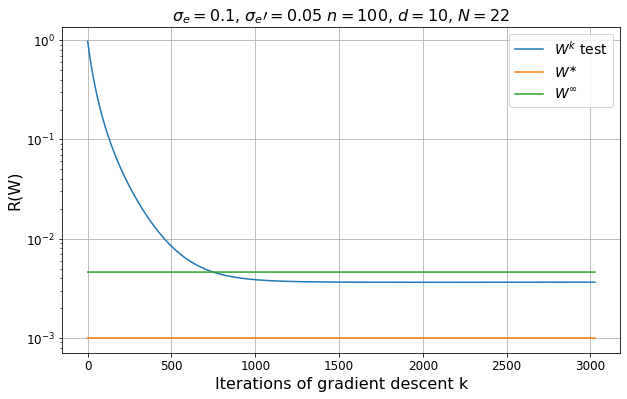

Converged gradient descent: test risk: 0.00201794
4.798525912188081
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Stopped at iteration 3059 due to early stopping
Gradient descent: test risk last: 0.00169286; test risk early stopped: 0.00168785; train loss: 3.851766450679861e-05


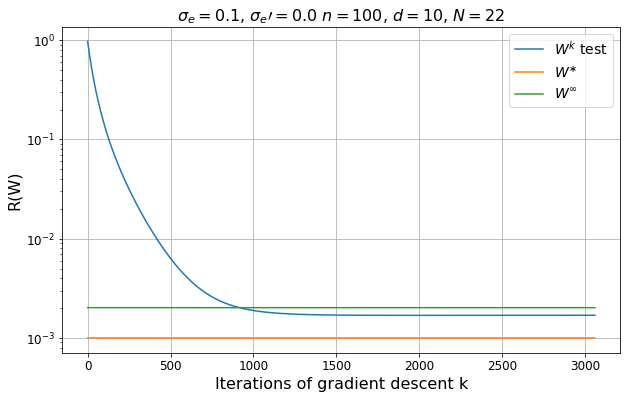



*****training size (N) = 24*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.04737224
4.594238785600079
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Stopped at iteration 2031 due to early stopping
Gradient descent: test risk last: 0.0347037; test risk early stopped: 0.03422377; train loss: 0.0017880144296213984


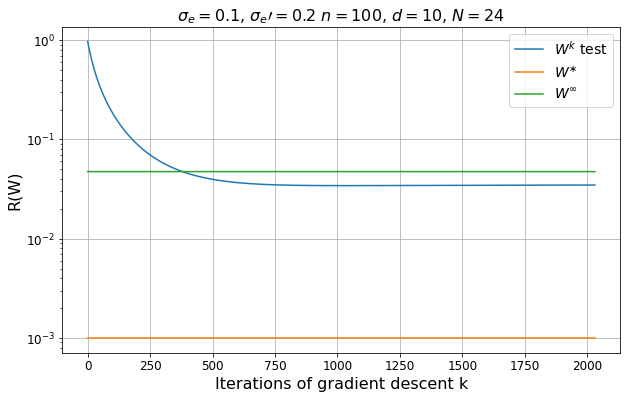

Converged gradient descent: test risk: 0.0132265
4.594238785600079
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Stopped at iteration 3623 due to early stopping
Gradient descent: test risk last: 0.01011648; 

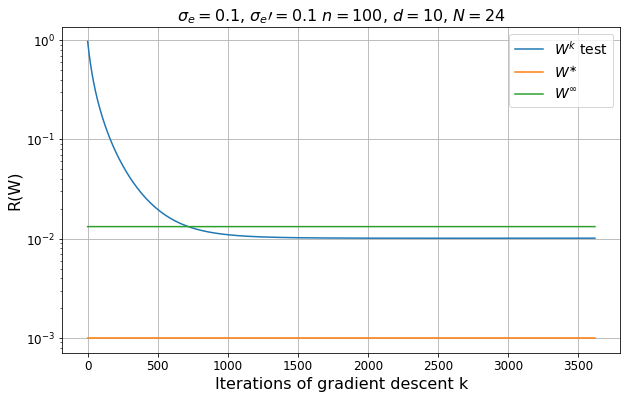

Converged gradient descent: test risk: 0.00483997
4.594238785600079
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Stopped at iteration 3717 due to early stopping
Gradient descent: test

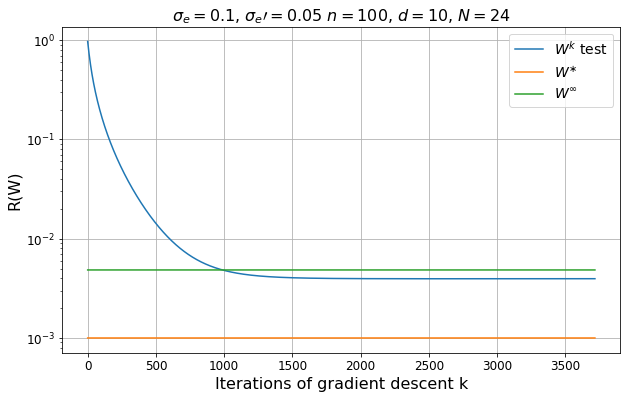

Converged gradient descent: test risk: 0.00209647
4.594238785600079
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
I

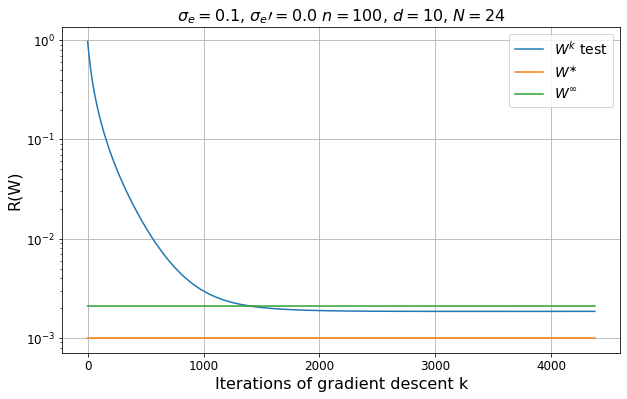



*****training size (N) = 30*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.04469746
4.1092120917871435
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Stopped at iteration 1533 due to early stopping
Gradient descent: test risk last: 0.02353062; test risk early stopped: 0.02267139; train loss: 0.0022754212841391563


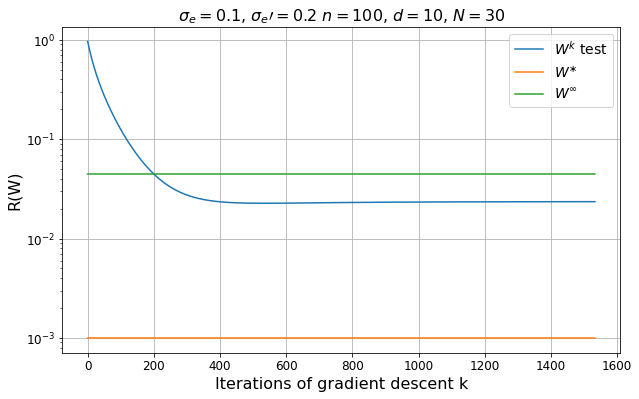

Converged gradient descent: test risk: 0.01220978
4.1092120917871435
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Stopped at iteration 2595 due to early stopping
Gradient descent: test risk last: 0.00736709; test risk early stopped: 0.00735113; train loss: 0.0005354584427550435


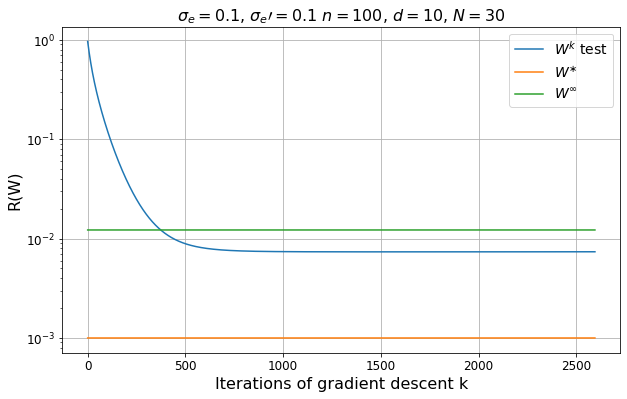

Converged gradient descent: test risk: 0.0045856
4.1092120917871435
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Stopped at iteration 3047 due to early stopping
Gradient descent: test risk last: 0.00309218; test risk early stopped: 0.00308843; train loss: 0.00016504696395713836


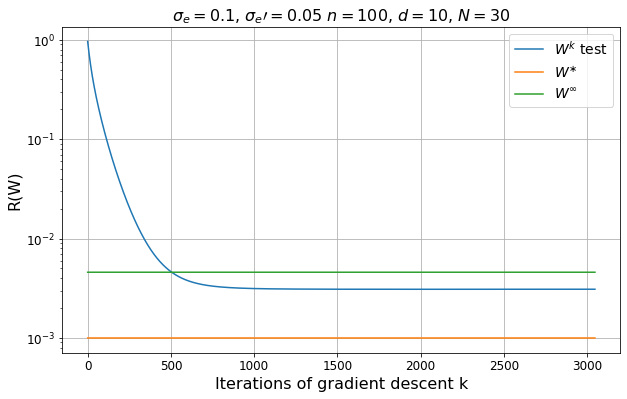

Converged gradient descent: test risk: 0.00205629
4.1092120917871435
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Stopped at iteration 3188 due to early stopping
Gradient descent: test risk last: 0.00161662; test risk early stopped: 0.00161524; train loss: 4.863606227445416e-05


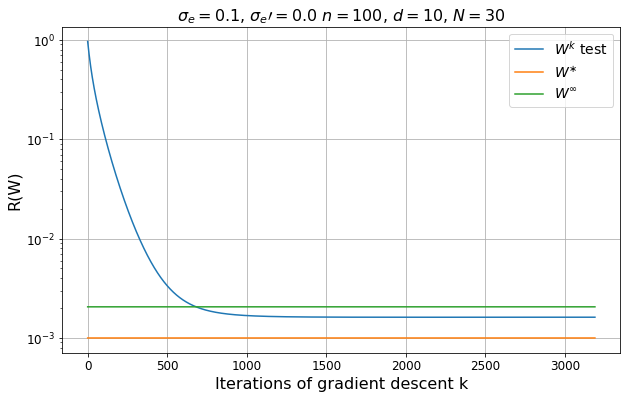



*****training size (N) = 36*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.04203304
3.7511802604080127
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Stopped at iteration 1539 due to early stopping
Gradient descent: test risk last: 0.0186173; test risk early stopped: 0.01836739; train loss: 0.0024410150945186615


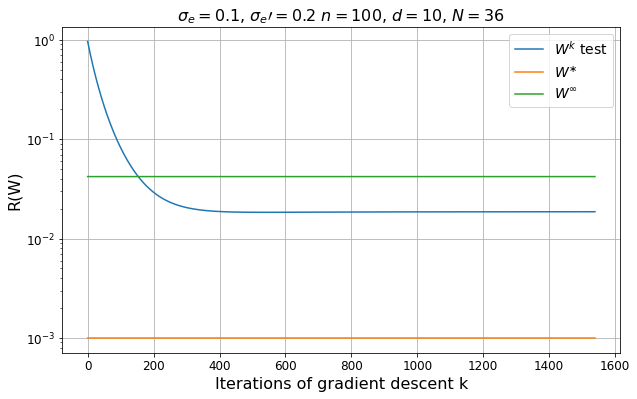

Converged gradient descent: test risk: 0.01293223
3.7511802604080127
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Stopped at iteration 2098 due to early stopping
Gradient descent: test risk last: 0.0058285; test risk early stopped: 0.00579279; train loss: 0.0006522761541418731


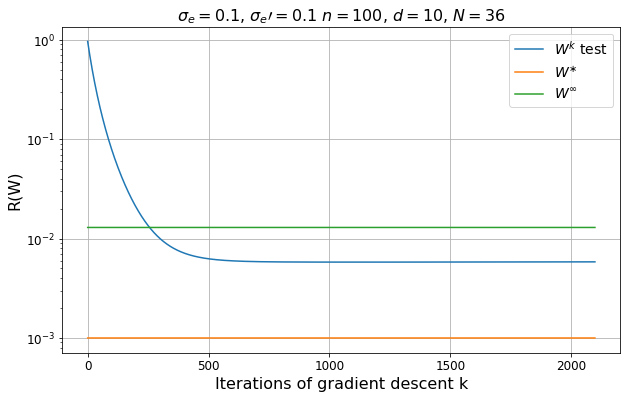

Converged gradient descent: test risk: 0.00437581
3.7511802604080127
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Stopped at iteration 2252 due to early stopping
Gradient descent: test risk last: 0.00238977; test risk early stopped: 0.00238149; train loss: 0.00019866118964273483


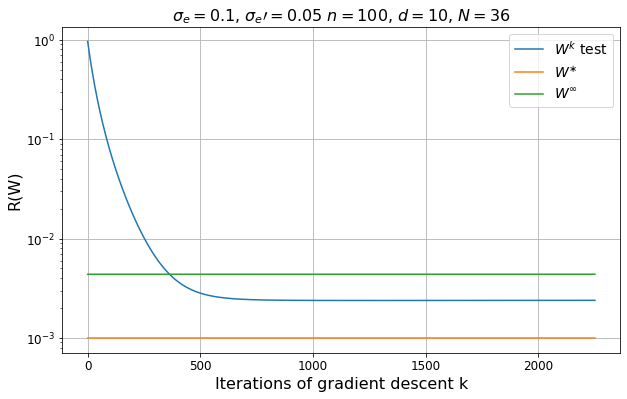

Converged gradient descent: test risk: 0.00201739
3.7511802604080127
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Stopped at iteration 2579 due to early stopping
Gradient descent: test risk last: 0.00145476; test risk early stopped: 0.00145259; train loss: 5.420578600023873e-05


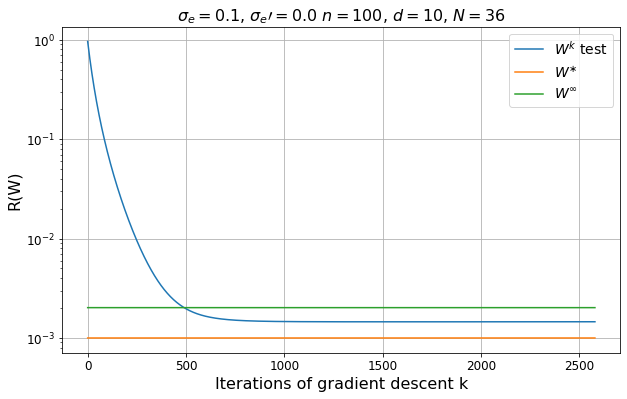



*****training size (N) = 44*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.04552496
3.3930702122075562
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1321 due to early stopping
Gradient descent: test risk last: 0.01246799; test risk early stopped: 0.01216745; train loss: 0.0027607667725533247


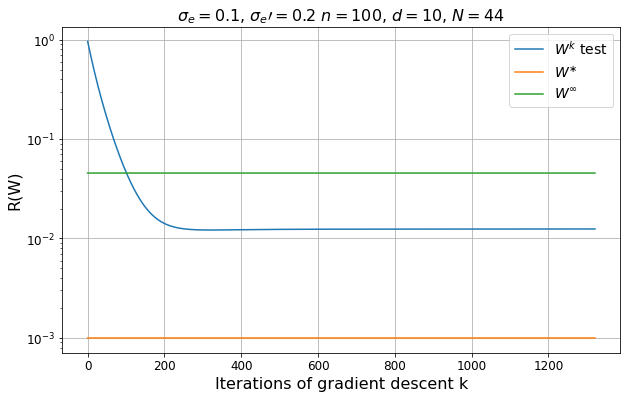

Converged gradient descent: test risk: 0.01303164
3.3930702122075562
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1387 due to early stopping
Gradient descent: test risk last: 0.00461248; test risk early stopped: 0.00453786; train loss: 0.000715658999979496


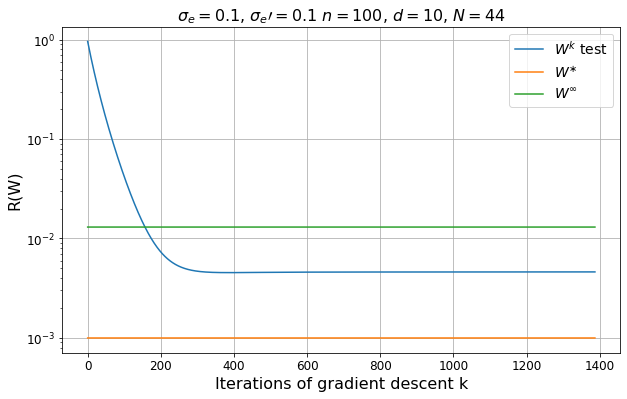

Converged gradient descent: test risk: 0.00441294
3.3930702122075562
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Stopped at iteration 1636 due to early stopping
Gradient descent: test risk last: 0.00184939; test risk early stopped: 0.00184392; train loss: 0.00022450473625212908


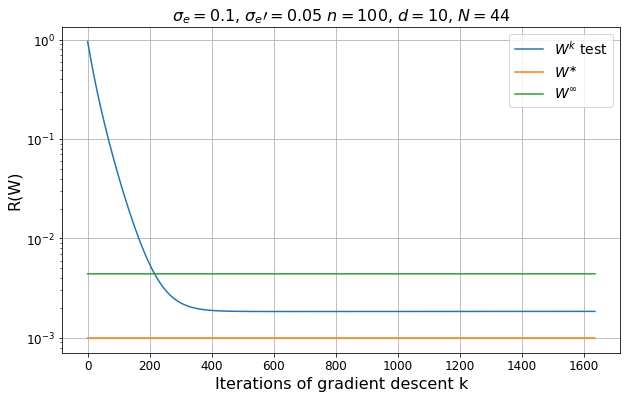

Converged gradient descent: test risk: 0.00192669
3.3930702122075562
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Stopped at iteration 1763 due to early stopping
Gradient descent: test risk last: 0.00123826; test risk early stopped: 0.00123679; train loss: 6.296572973951697e-05


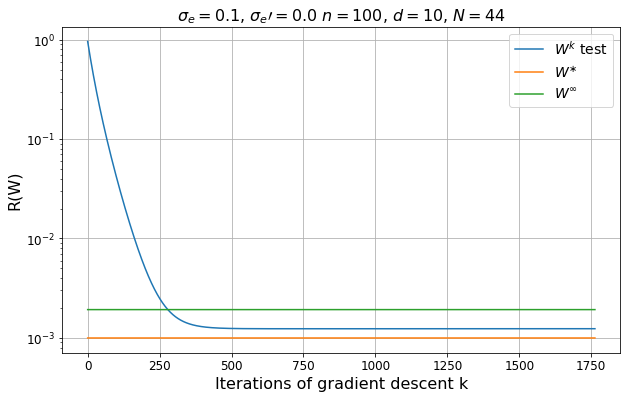



*****training size (N) = 64*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.08771142
2.8133851953060094
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1339 due to early stopping
Gradient descent: test risk last: 0.0100212; test risk early stopped: 0.00991786; train loss: 0.0030728725250810385


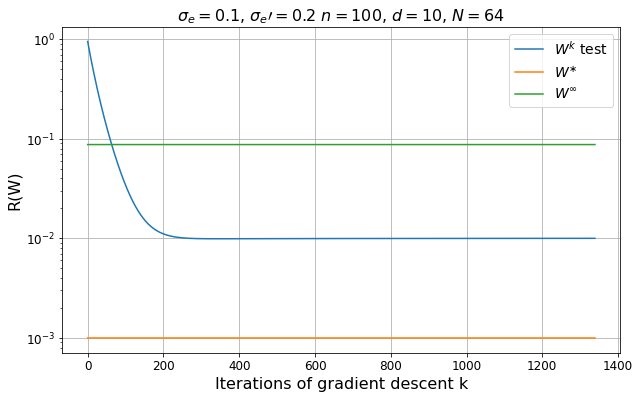

Converged gradient descent: test risk: 0.02393723
2.8133851953060094
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1368 due to early stopping
Gradient descent: test risk last: 0.00317856; test risk early stopped: 0.00313821; train loss: 0.0008295020088553429


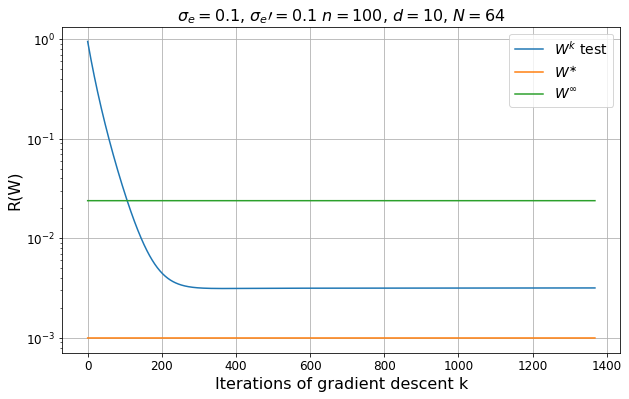

Converged gradient descent: test risk: 0.0080294
2.8133851953060094
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Stopped at iteration 1409 due to early stopping
Gradient descent: test risk last: 0.00162544; test risk early stopped: 0.00161367; train loss: 0.00026129171601496637


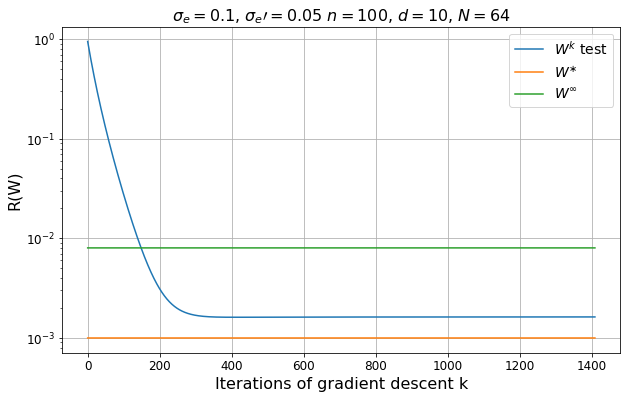

Converged gradient descent: test risk: 0.00290904
2.8133851953060094
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Stopped at iteration 1458 due to early stopping
Gradient descent: test risk last: 0.0011793; test risk early stopped: 0.00117551; train loss: 7.605105201946571e-05


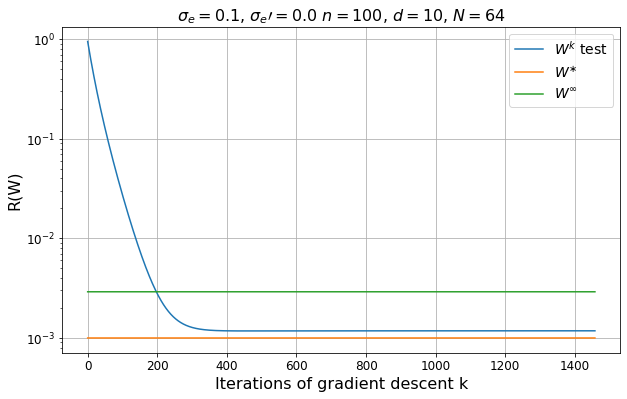



*****training size (N) = 100*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 3.42338686
2.2507081562448077
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Stopped at iteration 1291 due to early stopping
Gradient descent: test risk last: 0.00577285; test risk early stopped: 0.00570323; train loss: 0.0034235541243106127


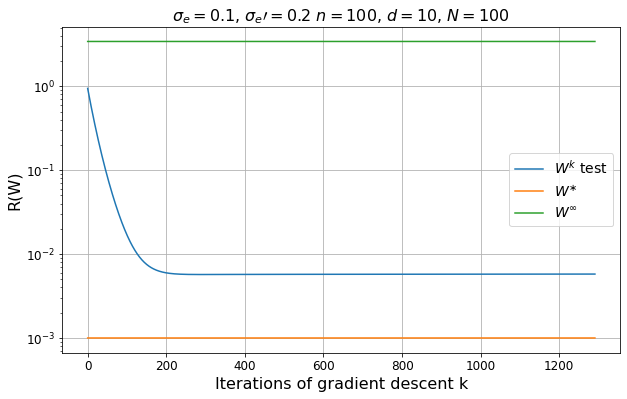

Converged gradient descent: test risk: 0.99232429
2.2507081562448077
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Stopped at iteration 1431 due to early stopping
Gradient descent: test risk last: 0.00233834; test risk early stopped: 0.00232163; train loss: 0.0009288203436881304


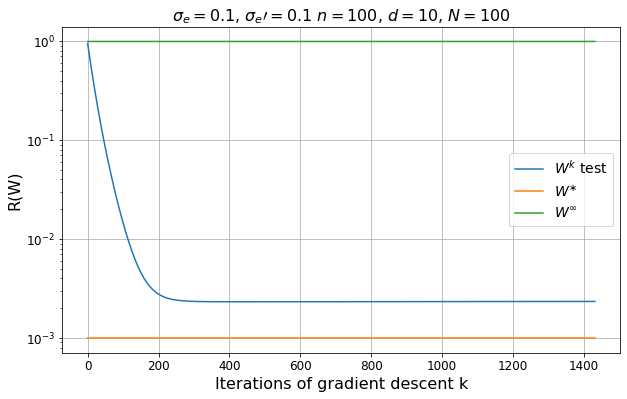

Converged gradient descent: test risk: 0.28212078
2.2507081562448077
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Stopped at iteration 1478 due to early stopping
Gradient descent: test risk last: 0.00147483; test risk early stopped: 0.00146691; train loss: 0.0002947667962871492


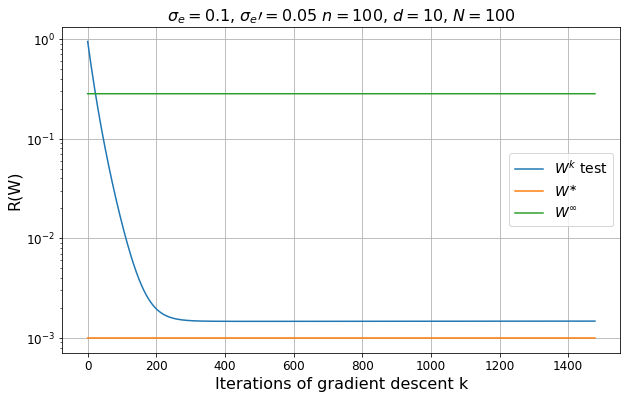

Converged gradient descent: test risk: 0.08716023
2.2507081562448077
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Stopped at iteration 1590 due to early stopping
Gradient descent: test risk last: 0.00113626; test risk early stopped: 0.0011332; train loss: 8.641423482913524e-05


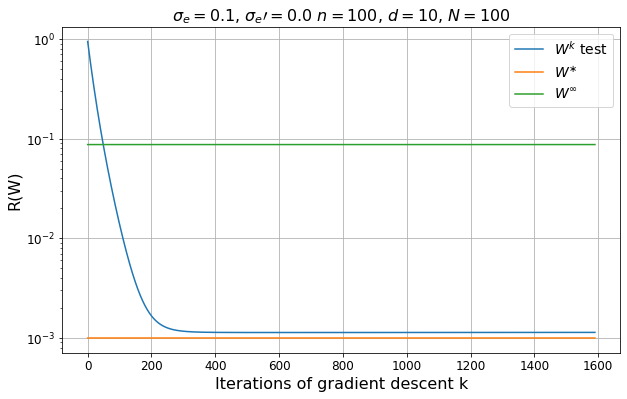



*****training size (N) = 164*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.06791527
1.7575077983706007
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Stopped at iteration 1220 due to early stopping
Gradient descent: test risk last: 0.0038104; test risk early stopped: 0.00375498; train loss: 0.003701877547428012


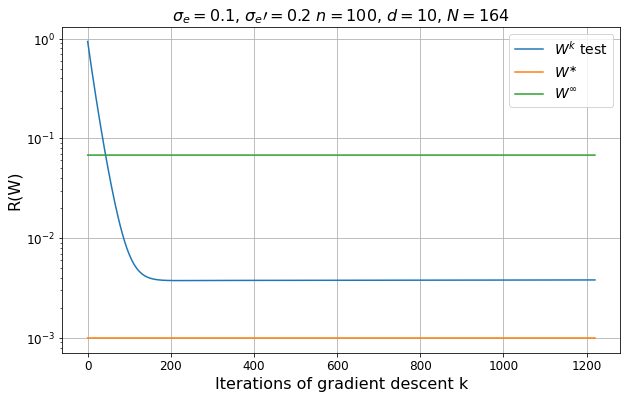

Converged gradient descent: test risk: 0.01909776
1.7575077983706007
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1306 due to early stopping
Gradient descent: test risk last: 0.00177297; test risk early stopped: 0.00176099; train loss: 0.0009784207213670015


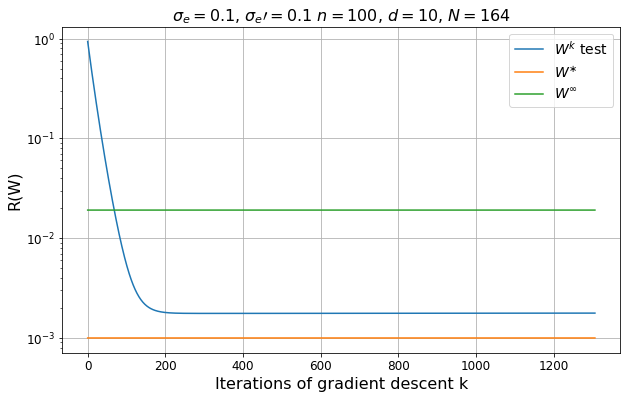

Converged gradient descent: test risk: 0.00656723
1.7575077983706007
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1330 due to early stopping
Gradient descent: test risk last: 0.00124264; test risk early stopped: 0.00123961; train loss: 0.0003116790030617267


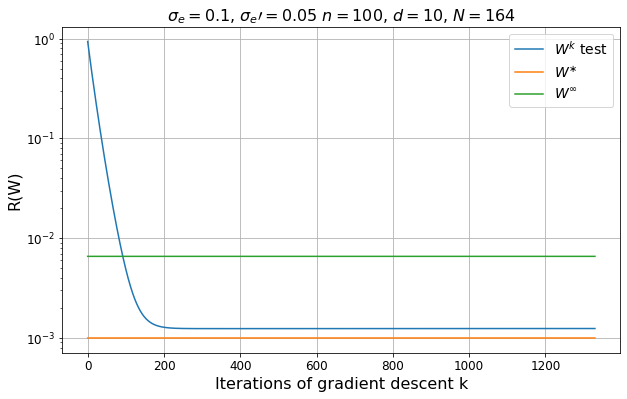

Converged gradient descent: test risk: 0.00257632
1.7575077983706007
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1330 due to early stopping
Gradient descent: test risk last: 0.00107472; test risk early stopped: 0.00107409; train loss: 8.963402797235176e-05


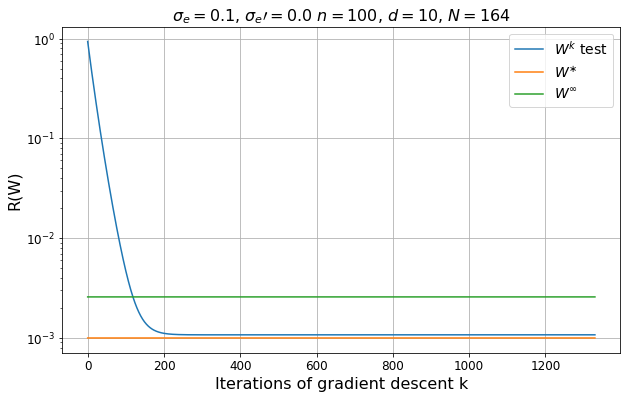



*****training size (N) = 256*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.02830404
1.4066925976530047
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Stopped at iteration 1256 due to early stopping
Gradient descent: test risk last: 0.00274393; test risk early stopped: 0.0027081; train loss: 0.0038440802600234747


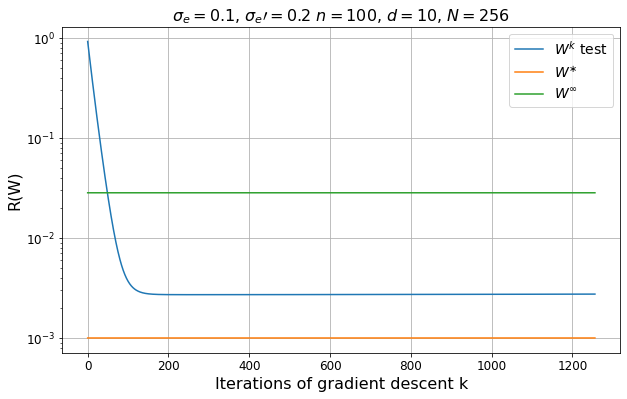

Converged gradient descent: test risk: 0.00835758
1.4066925976530047
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1318 due to early stopping
Gradient descent: test risk last: 0.00145261; test risk early stopped: 0.00144181; train loss: 0.0010205049766227603


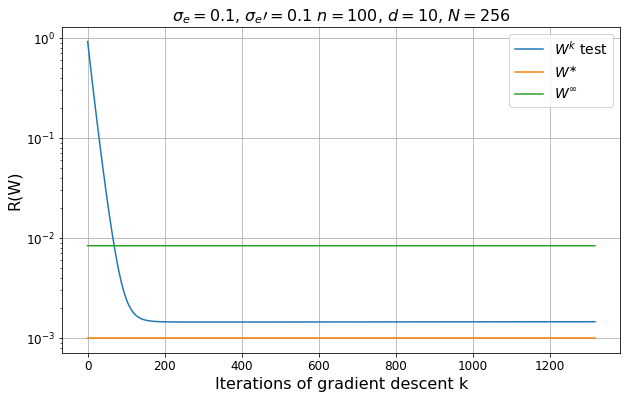

Converged gradient descent: test risk: 0.00324444
1.4066925976530047
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1347 due to early stopping
Gradient descent: test risk last: 0.00114407; test risk early stopped: 0.00114115; train loss: 0.0003250788722652942


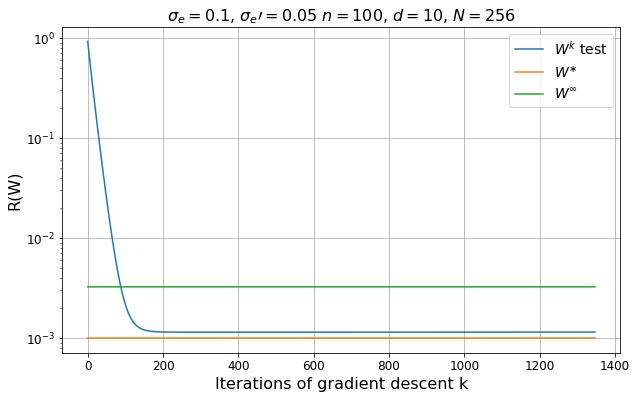

Converged gradient descent: test risk: 0.00160859
1.4066925976530047
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1374 due to early stopping
Gradient descent: test risk last: 0.00104308; test risk early stopped: 0.00104235; train loss: 9.257683996111155e-05


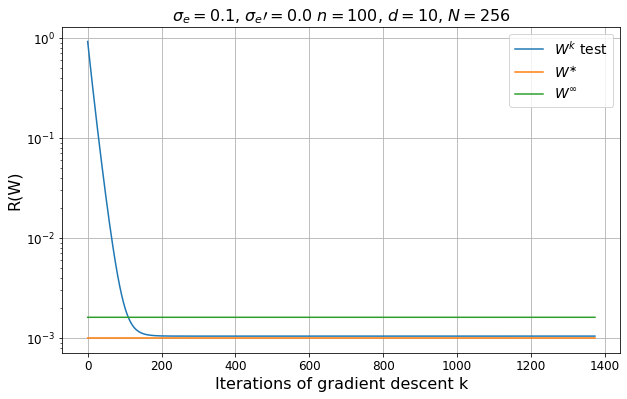



*****training size (N) = 512*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.01117371
0.9946818748453593
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1175 due to early stopping
Gradient descent: test risk last: 0.00191453; test risk early stopped: 0.0018917; train loss: 0.003923605661839247


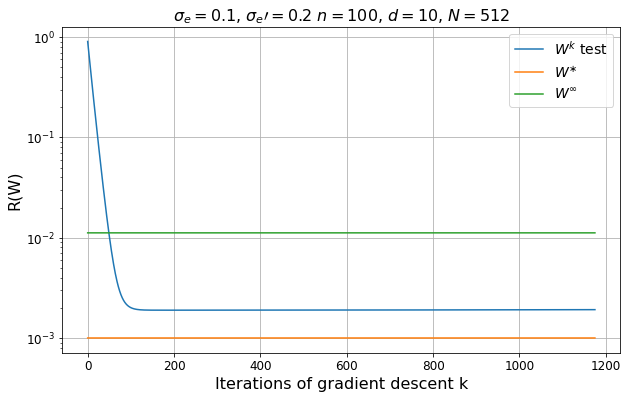

Converged gradient descent: test risk: 0.00359791
0.9946818748453593
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1198 due to early stopping
Gradient descent: test risk last: 0.0012243; test risk early stopped: 0.00121804; train loss: 0.00105142907705158


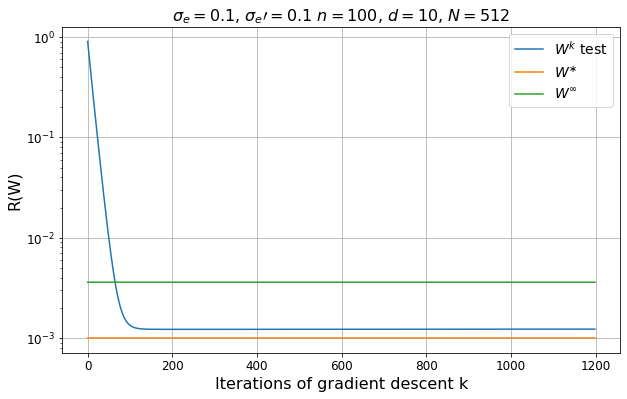

Converged gradient descent: test risk: 0.00187377
0.9946818748453593
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1163 due to early stopping
Gradient descent: test risk last: 0.00107099; test risk early stopped: 0.0010682; train loss: 0.00033742934465408325


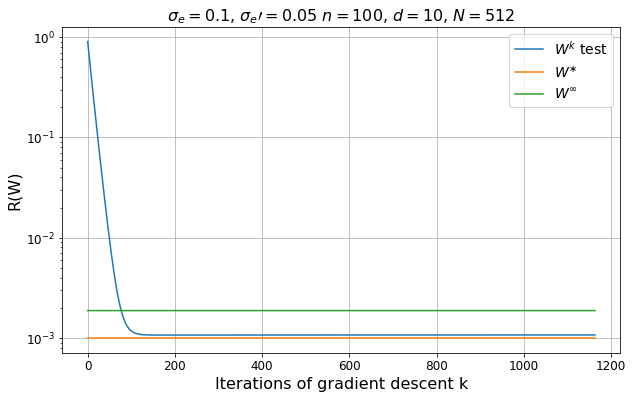

Converged gradient descent: test risk: 0.00123526
0.9946818748453593
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1165 due to early stopping
Gradient descent: test risk last: 0.00101401; test risk early stopped: 0.0010128; train loss: 9.517832950223237e-05


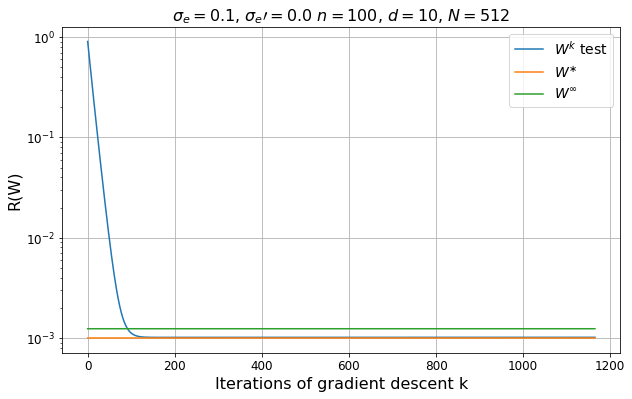



*****training size (N) = 1024*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.00547769
0.7033462988265023
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1128 due to early stopping
Gradient descent: test risk last: 0.00144623; test risk early stopped: 0.00143083; train loss: 0.004011557903140783


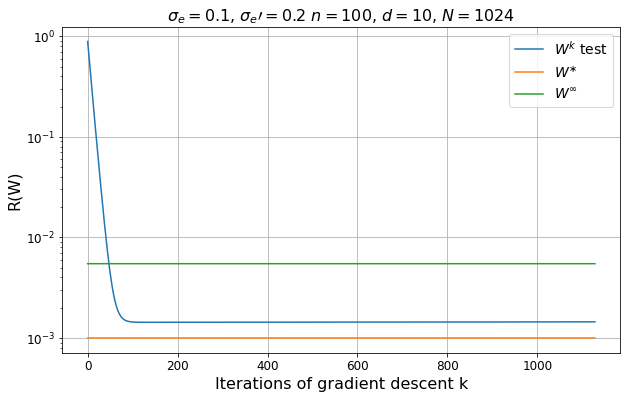

Converged gradient descent: test risk: 0.00218533
0.7033462988265023
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1178 due to early stopping
Gradient descent: test risk last: 0.00111441; test risk early stopped: 0.00111031; train loss: 0.0010744608007371426


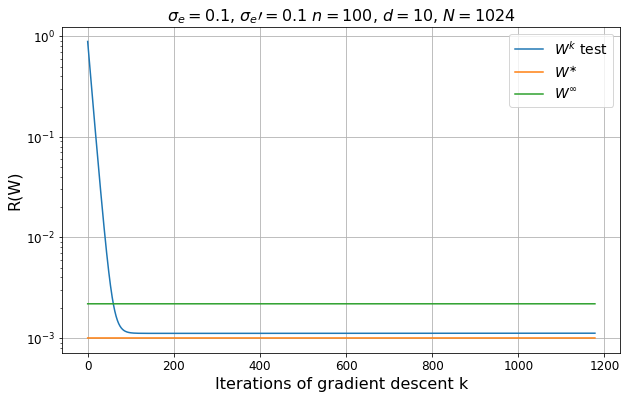

Converged gradient descent: test risk: 0.00136986
0.7033462988265023
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1155 due to early stopping
Gradient descent: test risk last: 0.00103428; test risk early stopped: 0.00103305; train loss: 0.00034085626248270273


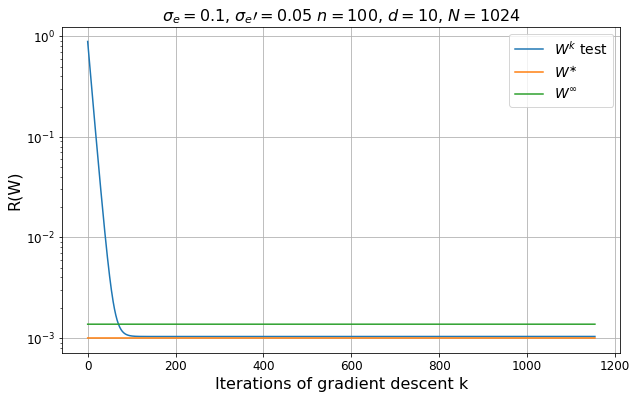

Converged gradient descent: test risk: 0.00110533
0.7033462988265023
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1167 due to early stopping
Gradient descent: test risk last: 0.00100794; test risk early stopped: 0.00100761; train loss: 9.606294770492241e-05


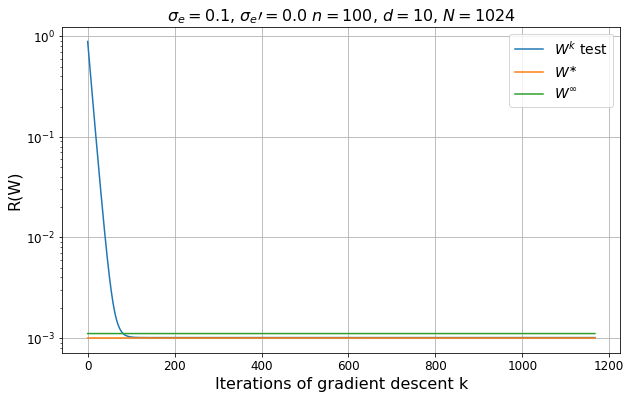



*****training size (N) = 2048*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.00309686
0.49734093742267965
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1121 due to early stopping
Gradient descent: test risk last: 0.00121977; test risk early stopped: 0.00121083; train loss: 0.004051506519317627


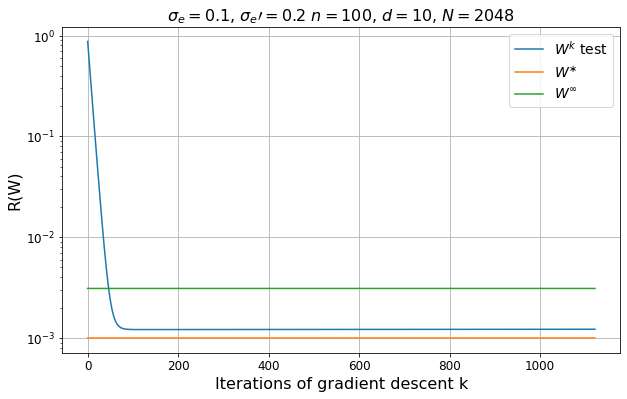

Converged gradient descent: test risk: 0.00155141
0.49734093742267965
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1120 due to early stopping
Gradient descent: test risk last: 0.00105541; test risk early stopped: 0.00105284; train loss: 0.0010876148007810116


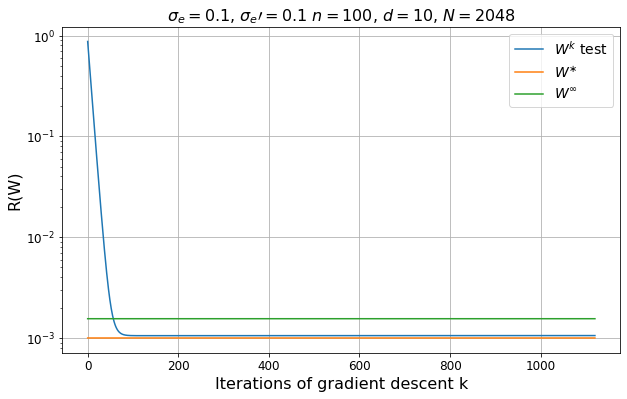

Converged gradient descent: test risk: 0.00118233
0.49734093742267965
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1187 due to early stopping
Gradient descent: test risk last: 0.00101628; test risk early stopped: 0.00101542; train loss: 0.00034584838431328535


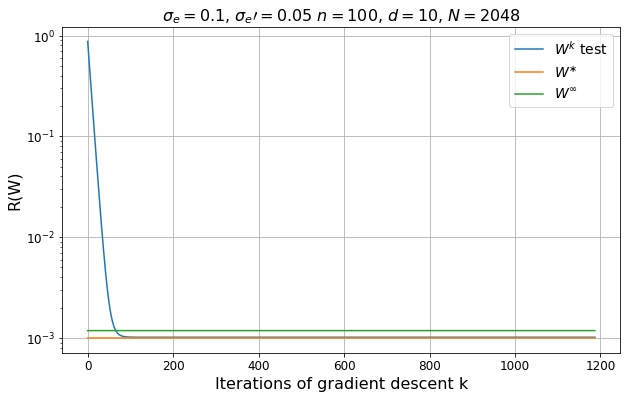

Converged gradient descent: test risk: 0.00105157
0.49734093742267965
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1183 due to early stopping
Gradient descent: test risk last: 0.00100352; test risk early stopped: 0.00100329; train loss: 9.996455628424883e-05


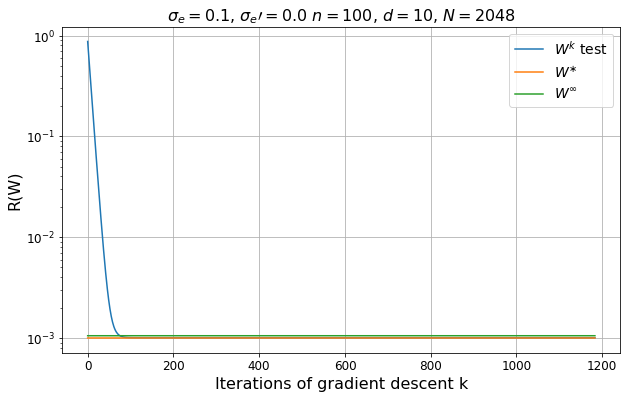



*****training size (N) = 4096*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.00203346
0.3516731494132512
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1137 due to early stopping
Gradient descent: test risk last: 0.00111243; test risk early stopped: 0.00110674; train loss: 0.0040747798047959805


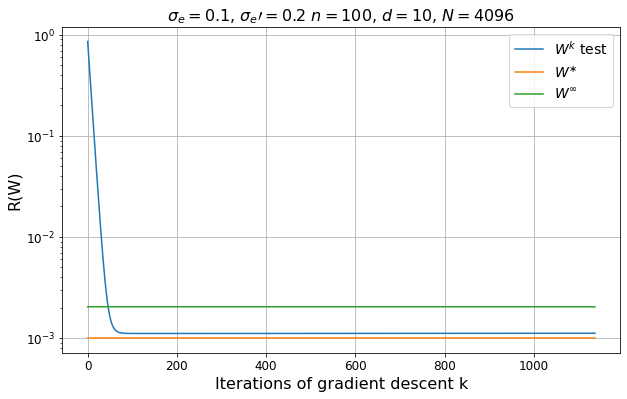

Converged gradient descent: test risk: 0.0012808
0.3516731494132512
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1147 due to early stopping
Gradient descent: test risk last: 0.00102713; test risk early stopped: 0.00102558; train loss: 0.001092828344553709


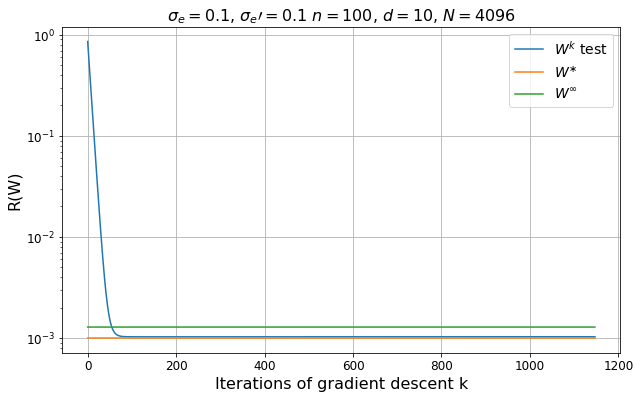

Converged gradient descent: test risk: 0.00108822
0.3516731494132512
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1166 due to early stopping
Gradient descent: test risk last: 0.00100892; test risk early stopped: 0.00100841; train loss: 0.0003472579992376268


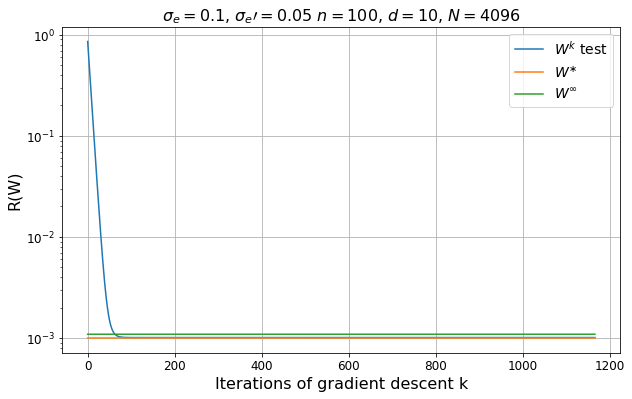

Converged gradient descent: test risk: 0.0010237
0.3516731494132512
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1171 due to early stopping
Gradient descent: test risk last: 0.00100191; test risk early stopped: 0.00100177; train loss: 9.883577149594203e-05


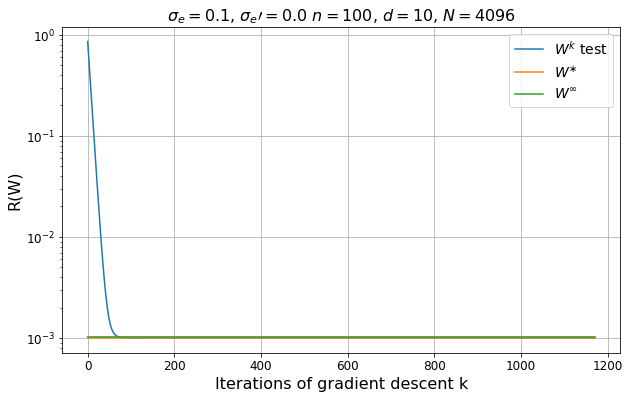



*****training size (N) = 8192*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.00150795
0.24867046871133983
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1106 due to early stopping
Gradient descent: test risk last: 0.00105192; test risk early stopped: 0.00104869; train loss: 0.004078865051269531


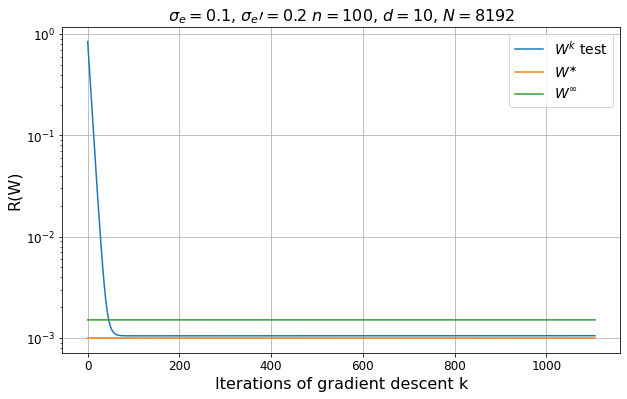

Converged gradient descent: test risk: 0.00113568
0.24867046871133983
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1111 due to early stopping
Gradient descent: test risk last: 0.00101356; test risk early stopped: 0.0010127; train loss: 0.0010973714524880052


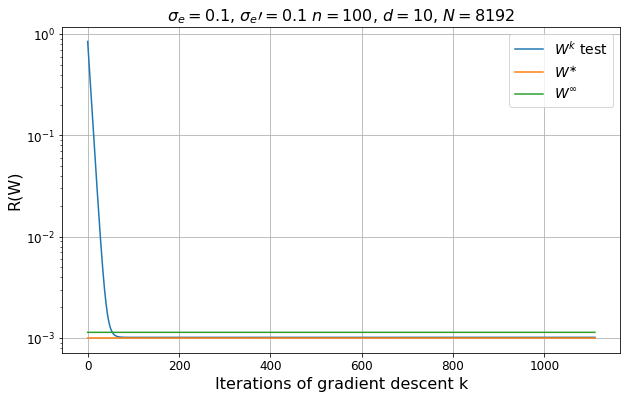

Converged gradient descent: test risk: 0.00104159
0.24867046871133983
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1111 due to early stopping
Gradient descent: test risk last: 0.00100395; test risk early stopped: 0.00100368; train loss: 0.00034808527561835945


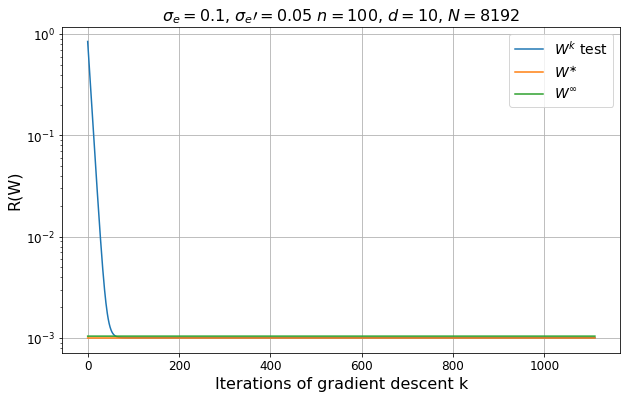

Converged gradient descent: test risk: 0.00101133
0.24867046871133983
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1114 due to early stopping
Gradient descent: test risk last: 0.00100034; test risk early stopped: 0.00100026; train loss: 9.926511120283976e-05


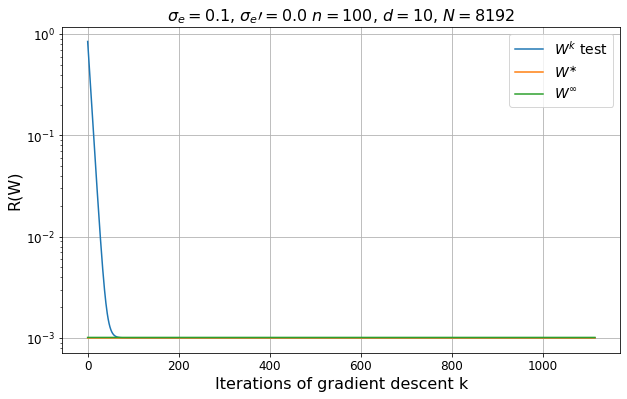



*****training size (N) = 16384*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.00125438
0.1758365747066256
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1122 due to early stopping
Gradient descent: test risk last: 0.00102753; test risk early stopped: 0.00102573; train loss: 0.0040876553393900394


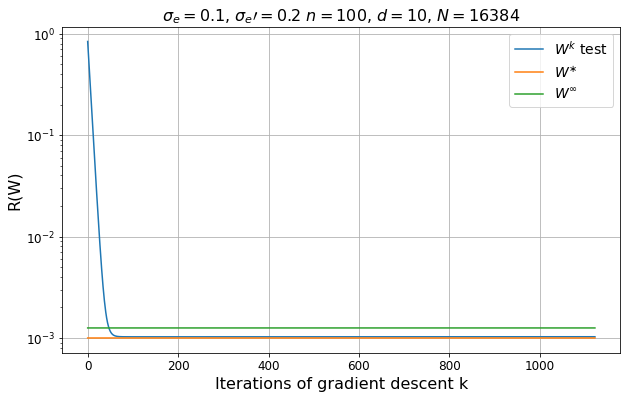

Converged gradient descent: test risk: 0.00106752
0.1758365747066256
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1143 due to early stopping
Gradient descent: test risk last: 0.00100669; test risk early stopped: 0.0010062; train loss: 0.001098343636840582


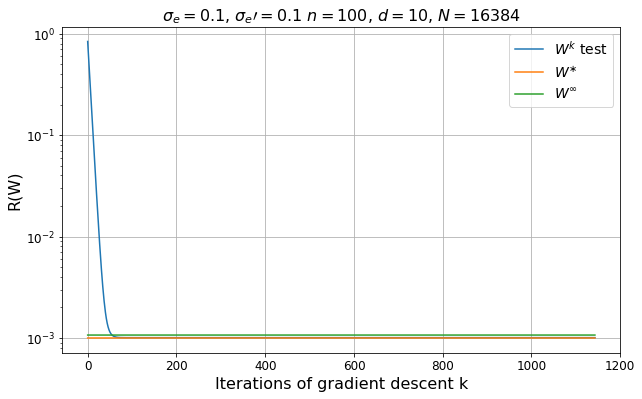

Converged gradient descent: test risk: 0.00102036
0.1758365747066256
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1142 due to early stopping
Gradient descent: test risk last: 0.00100134; test risk early stopped: 0.00100119; train loss: 0.0003488984366413206


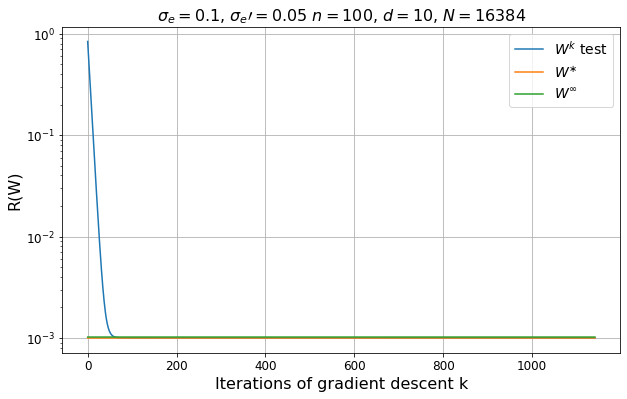

Converged gradient descent: test risk: 0.00100542
0.1758365747066256
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1146 due to early stopping
Gradient descent: test risk last: 0.00099974; test risk early stopped: 0.00099969; train loss: 9.946099453372881e-05


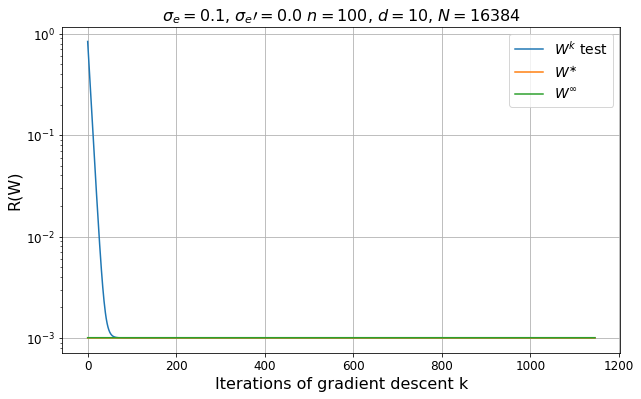



**********run 1**********
*****training size (N) = 1*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.90296347
22.507081562448075
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Stopped at iteration 273 due to convergence
Gradient descent: test risk last: 0.90296346; test risk early stopped: 0.90290356; train loss: 3.085599402938635e-14
Converged gradient descent: test risk: 0.90090715
22.507081562448075
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Stopped at iteration 273 due to convergence
Gradient descent: test risk last: 0.9009071; test risk early stopped: 0.9008882; train loss: 3.068745480167348e-14
Converged gradient descent: test risk: 0.90034918
22.507081562448075
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Stopped at iteration 279 due to convergence
Gradient descent: test risk last: 0.90034926; test risk early stopped: 0.90034783; train loss: 2.909039789654802e-14
Converged gradient d

Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
Iteration : 4100/30000
Iteration : 4200/30000
Iteration : 4300/30000
Iteration : 4400/30000
Iteration : 4500/30000
Iteration : 4600/30000
Iteration : 4700/30000
Iteration : 4800/30000
Iteration : 4900/30000
Iteration : 5000/30000
Stopped at iteration 5072 due to early stopping
Gradient descent: test risk last: 0.20281877; test risk

Iteration : 17700/30000
Iteration : 17800/30000
Iteration : 17900/30000
Iteration : 18000/30000
Iteration : 18100/30000
Iteration : 18200/30000
Iteration : 18300/30000
Iteration : 18400/30000
Iteration : 18500/30000
Iteration : 18600/30000
Iteration : 18700/30000
Iteration : 18800/30000
Iteration : 18900/30000
Iteration : 19000/30000
Iteration : 19100/30000
Iteration : 19200/30000
Iteration : 19300/30000
Iteration : 19400/30000
Iteration : 19500/30000
Iteration : 19600/30000
Iteration : 19700/30000
Iteration : 19800/30000
Iteration : 19900/30000
Iteration : 20000/30000
Iteration : 20100/30000
Iteration : 20200/30000
Iteration : 20300/30000
Iteration : 20400/30000
Iteration : 20500/30000
Iteration : 20600/30000
Iteration : 20700/30000
Iteration : 20800/30000
Iteration : 20900/30000
Iteration : 21000/30000
Iteration : 21100/30000
Iteration : 21200/30000
Iteration : 21300/30000
Iteration : 21400/30000
Iteration : 21500/30000
Iteration : 21600/30000
Iteration : 21700/30000
Iteration : 2180

Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Stopped at iteration 1984 due to early stopping
Gradient descent: test risk last: 0.15157869; test risk early stopped: 0.14877264; train loss: 0.0005790918366983533
Converged gradient descent: test risk: 0.08248721
6.4972347993761295
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iter

Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
Iteration : 4100/30000
Iteration : 4200/30000
Iteration : 4300/30000
Iteration : 4400/30000
Iteration : 4500/30000
Iteration : 4600/30000
Iteration : 4700/30000
Iteration : 4800/30000
Iteration : 4900/30000
Iteration : 5000/30000
Iteration : 5100/30000
Iteration : 5200/30000
Iteration : 5300/30000
Iteration : 5400/30000
Iteration : 5500/30000
Iteration : 5600/30000
Iteration : 5700/30000
Iteration : 5800/30000
Iteration : 5900/30000
Iteration : 6000/30000
Iteration : 6100/30000
Iteration : 6200/30000
Iteration : 6300/30000
Iteration : 6400/30000
Iteration : 6500/30000
Iteration : 6600/30000
Iteration : 6700/30000
Iteration :

Iteration : 6600/30000
Iteration : 6700/30000
Iteration : 6800/30000
Iteration : 6900/30000
Iteration : 7000/30000
Iteration : 7100/30000
Iteration : 7200/30000
Iteration : 7300/30000
Iteration : 7400/30000
Iteration : 7500/30000
Iteration : 7600/30000
Iteration : 7700/30000
Iteration : 7800/30000
Iteration : 7900/30000
Iteration : 8000/30000
Iteration : 8100/30000
Iteration : 8200/30000
Iteration : 8300/30000
Iteration : 8400/30000
Iteration : 8500/30000
Iteration : 8600/30000
Iteration : 8700/30000
Iteration : 8800/30000
Iteration : 8900/30000
Iteration : 9000/30000
Iteration : 9100/30000
Iteration : 9200/30000
Iteration : 9300/30000
Iteration : 9400/30000
Iteration : 9500/30000
Iteration : 9600/30000
Iteration : 9700/30000
Iteration : 9800/30000
Iteration : 9900/30000
Iteration : 10000/30000
Iteration : 10100/30000
Iteration : 10200/30000
Iteration : 10300/30000
Iteration : 10400/30000
Iteration : 10500/30000
Iteration : 10600/30000
Iteration : 10700/30000
Iteration : 10800/30000
It

Iteration : 3400/30000
Iteration : 3500/30000
Stopped at iteration 3587 due to early stopping
Gradient descent: test risk last: 0.00562363; test risk early stopped: 0.0056168; train loss: 3.7890345993218943e-05
Converged gradient descent: test risk: 0.00244649
6.015270570204102
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/300

Iteration : 8100/30000
Iteration : 8200/30000
Iteration : 8300/30000
Iteration : 8400/30000
Iteration : 8500/30000
Iteration : 8600/30000
Iteration : 8700/30000
Iteration : 8800/30000
Iteration : 8900/30000
Iteration : 9000/30000
Iteration : 9100/30000
Iteration : 9200/30000
Iteration : 9300/30000
Iteration : 9400/30000
Iteration : 9500/30000
Iteration : 9600/30000
Iteration : 9700/30000
Iteration : 9800/30000
Iteration : 9900/30000
Iteration : 10000/30000
Iteration : 10100/30000
Iteration : 10200/30000
Iteration : 10300/30000
Iteration : 10400/30000
Iteration : 10500/30000
Iteration : 10600/30000
Iteration : 10700/30000
Iteration : 10800/30000
Iteration : 10900/30000
Iteration : 11000/30000
Iteration : 11100/30000
Iteration : 11200/30000
Iteration : 11300/30000
Iteration : 11400/30000
Iteration : 11500/30000
Iteration : 11600/30000
Iteration : 11700/30000
Iteration : 11800/30000
Iteration : 11900/30000
Iteration : 12000/30000
Iteration : 12100/30000
Iteration : 12200/30000
Iteration :

Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Stopped at iteration 1856 due to early stopping
Gradient descent: test risk last: 0.04094174; test risk early stopped: 0.03897338; train loss: 0.0017180200666189194
Converged gradient descent: test risk: 0.01542006
4.798525912188081
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/3000

Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Stopped at iteration 2551 due to early stopping
Gradient descent: test risk last: 0.00770881; test risk early stopped: 0.00762953; train loss: 0.000533349288161844
Converged gradient descent: test risk: 0.00474082
4.1092120917871435
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Itera

Converged gradient descent: test risk: 0.08189326
2.8133851953060094
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1316 due to early stopping
Gradient descent: test risk last: 0.00812148; test risk early stopped: 0.00798099; train loss: 0.003167112125083804
Converged gradient descent: test risk: 0.02274778
2.8133851953060094
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Stopped at iteration 1527 due to

Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Stopped at iteration 1245 due to early stopping
Gradient descent: test risk last: 0.00112568; test risk early stopped: 0.00112263; train loss: 0.0003314449859317392
Converged gradient descent: test risk: 0.00171553
1.4066925976530047
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Stopped at iteration 1289 due to early stopping
Gradient descent: test risk last: 0.00102823; test risk early stopped: 0.00102719; train loss: 0.00010083918459713459


*****training size (N) = 512*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.0108379
0.9946818748453593
Iteration : 

Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1154 due to early stopping
Gradient descent: test risk last: 0.0010082; test risk early stopped: 0.00100772; train loss: 0.00034841123851947486
Converged gradient descent: test risk: 0.00102173
0.3516731494132512
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1168 due to early stopping
Gradient descent: test risk last: 0.0010014; test risk early stopped: 0.00100127; train loss: 9.9837219750043e-05


*****training size (N) = 8192*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.

Converged gradient descent: test risk: 0.80279372
15.914909997525749
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Stopped at iteration 2179 due to early stopping
Gradient descent: test risk last: 0.80279374; test risk early stopped: 0.80279374; train loss: 2.8487452739638097e-13
Converged gradient descent: test risk: 0.80116501
15.914909997525749
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iterat

Iteration : 7300/30000
Iteration : 7400/30000
Iteration : 7500/30000
Iteration : 7600/30000
Iteration : 7700/30000
Iteration : 7800/30000
Iteration : 7900/30000
Iteration : 8000/30000
Iteration : 8100/30000
Iteration : 8200/30000
Stopped at iteration 8201 due to early stopping
Gradient descent: test risk last: 0.21206369; test risk early stopped: 0.21206369; train loss: 7.616465791393523e-10
Converged gradient descent: test risk: 0.20520028
7.957454998762874
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/300

Iteration : 20100/30000
Iteration : 20200/30000
Iteration : 20300/30000
Iteration : 20400/30000
Iteration : 20500/30000
Iteration : 20600/30000
Iteration : 20700/30000
Iteration : 20800/30000
Iteration : 20900/30000
Iteration : 21000/30000
Iteration : 21100/30000
Iteration : 21200/30000
Iteration : 21300/30000
Iteration : 21400/30000
Iteration : 21500/30000
Iteration : 21600/30000
Iteration : 21700/30000
Iteration : 21800/30000
Iteration : 21900/30000
Iteration : 22000/30000
Iteration : 22100/30000
Iteration : 22200/30000
Iteration : 22300/30000
Iteration : 22400/30000
Iteration : 22500/30000
Iteration : 22600/30000
Iteration : 22700/30000
Iteration : 22800/30000
Iteration : 22900/30000
Iteration : 23000/30000
Iteration : 23100/30000
Iteration : 23200/30000
Iteration : 23300/30000
Iteration : 23400/30000
Iteration : 23500/30000
Iteration : 23600/30000
Iteration : 23700/30000
Iteration : 23800/30000
Iteration : 23900/30000
Iteration : 24000/30000
Iteration : 24100/30000
Iteration : 2420

Iteration : 29200/30000
Iteration : 29300/30000
Iteration : 29400/30000
Iteration : 29500/30000
Iteration : 29600/30000
Iteration : 29700/30000
Iteration : 29800/30000
Iteration : 29900/30000
Gradient descent: test risk last: 0.07431567; test risk early stopped: 0.07431567; train loss: 8.272211360349502e-09
Converged gradient descent: test risk: 0.06345116
7.117364122051717
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 27

Iteration : 2100/30000
Stopped at iteration 2173 due to early stopping
Gradient descent: test risk last: 0.17025627; test risk early stopped: 0.16353752; train loss: 0.0005297375610098243
Converged gradient descent: test risk: 0.04644696
6.4972347993761295
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30

Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
Iteration : 4100/30000
Iteration : 4200/30000
Iteration : 4300/30000
Iteration : 4400/30000
Iteration : 4500/30

Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
Iteration : 4100/30000
Iteration : 4200/30000
Iteration : 4300/30000
Iteration : 4400/30000
Iteration : 4500/30000
Iteration : 4600/30000
Iteration : 4700/

Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Stopped at iteration 3193 due to early stopping
Gradient descent: test risk last: 0.00381871; test risk early stopped: 0.00381442; train loss: 0.00011888943845406175
Converged gradient descent: test risk: 0.00225064
4.798525912188081
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30

Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Stopped at iteration 1455 due to early stopping
Gradient descent: test risk last: 0.01844962; test risk early stopped: 0.01813454; train loss: 0.0024787900038063526
Converged gradient descent: test risk: 0.01138172
3.7511802604080127
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Stopped at iteration 1749 due to early stopping
Gradient descent: test risk last: 0.00537492; test risk early stopped: 0.00533806; train loss: 0.0006457625422626734
Converged gradient

Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Stopped at iteration 1425 due to early stopping
Gradient descent: test risk last: 0.0022263; test risk early stopped: 0.00221049; train loss: 0.0008994914242066443
Converged gradient descent: test risk: 0.75820707
2.2507081562448077
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Stopped at iteration 1506 due to early stopping
Gradient descent: test risk last: 0.00146631; test risk early stopped: 0.00146103; train loss: 0.0002841736131813377
Converged gradient descent: test risk: 0.18548487
2.2507081562448077
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000


Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1155 due to early stopping
Gradient descent: test risk last: 0.00138491; test risk early stopped: 0.00136998; train loss: 0.003965083509683609
Converged gradient descent: test risk: 0.00217816
0.7033462988265023
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1188 due to early stopping
Gradient descent: test risk last: 0.00111308; test risk early stopped: 0.00110904; train loss: 0.0010783475590869784
Converged gradient descent: test risk: 0.00138451
0.7033462988265023
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Itera

Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Stopped at iteration 1095 due to early stopping
Gradient descent: test risk last: 0.00102698; test risk early stopped: 0.00102519; train loss: 0.0040968009270727634
Converged gradient descent: test risk: 0.00106599
0.1758365747066256
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Stopped at iteration 1093 due to early stopping
Gradient descent: test risk last: 0.00100594; test risk early stopped: 0.00100542; train loss: 0.001099919667467475
Converged gradient descent: test risk: 0.0010205
0.1758365747066256
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteratio

Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
Iteration : 4100/30000
Iteration : 4200/30000
Iteration : 4300/30000
Iteration : 4400/300

Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
Stopped at iteration 4039 due to early stopping
Gradient descent: test risk last: 0.14306298; test risk early stopped: 0.14265302; train loss: 6.221048533916473e-05
Converged gradient descent: test risk: 0.11670006
7.117364122051717
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/300

Iteration : 6500/30000
Iteration : 6600/30000
Iteration : 6700/30000
Iteration : 6800/30000
Iteration : 6900/30000
Iteration : 7000/30000
Iteration : 7100/30000
Iteration : 7200/30000
Iteration : 7300/30000
Iteration : 7400/30000
Iteration : 7500/30000
Iteration : 7600/30000
Iteration : 7700/30000
Iteration : 7800/30000
Iteration : 7900/30000
Iteration : 8000/30000
Iteration : 8100/30000
Iteration : 8200/30000
Iteration : 8300/30000
Iteration : 8400/30000
Iteration : 8500/30000
Iteration : 8600/30000
Iteration : 8700/30000
Iteration : 8800/30000
Iteration : 8900/30000
Iteration : 9000/30000
Iteration : 9100/30000
Iteration : 9200/30000
Iteration : 9300/30000
Iteration : 9400/30000
Iteration : 9500/30000
Iteration : 9600/30000
Iteration : 9700/30000
Iteration : 9800/30000
Iteration : 9900/30000
Iteration : 10000/30000
Iteration : 10100/30000
Iteration : 10200/30000
Iteration : 10300/30000
Iteration : 10400/30000
Iteration : 10500/30000
Iteration : 10600/30000
Iteration : 10700/30000
Ite

Iteration : 29700/30000
Iteration : 29800/30000
Iteration : 29900/30000
Gradient descent: test risk last: 0.00514427; test risk early stopped: 0.00514427; train loss: 7.41996757369634e-08


*****training size (N) = 14*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.06519793
6.015270570204102
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Stopped at iteration 1813 due to early stopping
Gradient descent: test risk last: 0.06046046; test risk early stopped: 0.05753649; train loss: 0.0007928067352622747
Converged gradient descent: test risk: 0.01704471
6.015270570204102
Iteration :

Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
Iteration : 4100/30000
Iteration : 4200/30000
Iteration : 4300/30000
Iteration : 4400/30000
Iteration : 4500/30000
Iteration : 4600/30000
Iteration : 4700/30000
Stopped at iteration 4704 due to early stopping
Gradient descent: test risk last: 0.00212228; test risk early stopped: 0.00212131; train loss: 2.401754136371892e-05


*****training size (N) = 18*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.06562621
5.30496999917525
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 8

Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Iteration : 3800/30000
Iteration : 3900/30000
Iteration : 4000/30000
Iteration : 4100/30000
Iteration : 4200/30000
Iteration : 4300/30000
Iteration : 4400/30000
Iteration : 4500/30000
Iteration : 4600/30000
Iteration : 4700/30000
Iteration : 4800/30000
Iteration : 4900/30000
Iteration : 5000/30000
Iteration : 5100/30000
Iteration : 

Converged gradient descent: test risk: 0.03862475
4.1092120917871435
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Stopped at iteration 1647 due to early stopping
Gradient descent: test risk last: 0.02127469; test risk early stopped: 0.02084884; train loss: 0.002196095185354352
Converged gradient descent: test risk: 0.01126827
4.1092120917871435
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration

Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Stopped at iteration 1781 due to early stopping
Gradient descent: test risk last: 0.00124405; test risk early stopped: 0.00124142; train loss: 6.197974289534613e-05


*****training size (N) = 64*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.08528206
2.8133851953060094
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1364 due to early stopping
Gradient descent: test risk last: 0.00774282; test risk early stopped: 0.00763304; 

Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1311 due to early stopping
Gradient descent: test risk last: 0.00148514; test risk early stopped: 0.00147653; train loss: 0.0009983720956370234
Converged gradient descent: test risk: 0.0032667
1.4066925976530047
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1328 due to early stopping
Gradient descent: test risk last: 0.0011497; test risk early stopped: 0.0011462; train loss: 0.00032120448304340243
Converged gradient descent: test risk: 0.00162321
1.4066925976530047
Iteration : 0/30000
It

Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1129 due to early stopping
Gradient descent: test risk last: 0.00102822; test risk early stopped: 0.00102668; train loss: 0.001089946716092527
Converged gradient descent: test risk: 0.00108918
0.3516731494132512
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1123 due to early stopping
Gradient descent: test risk last: 0.00100822; test risk early stopped: 0.00100774; train loss: 0.0003477303253021091
Converged gradient descent: test risk: 0.00102576
0.3516731494132512
Iteration : 0/30000
Itera

Iteration : 700/30000
Stopped at iteration 720 due to convergence
Gradient descent: test risk last: 0.80048645; test risk early stopped: 0.80048645; train loss: 7.425272419495088e-14


*****training size (N) = 4*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.62137145
11.253540781224038
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Stopped at iteration 1544 due to early stopping
Gradient descent: test risk last: 0.62136024; test risk early stopped: 0.62076122; train loss: 3.1209450579439135e-09
Converged gradient descent: test risk: 0.60638752
11.253540781224038
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/300

Iteration : 13600/30000
Iteration : 13700/30000
Iteration : 13800/30000
Iteration : 13900/30000
Iteration : 14000/30000
Iteration : 14100/30000
Stopped at iteration 14148 due to early stopping
Gradient descent: test risk last: 0.2171952; test risk early stopped: 0.2171952; train loss: 4.146758492140634e-10
Converged gradient descent: test risk: 0.20801789
7.957454998762874
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 270

Iteration : 7500/30000
Iteration : 7600/30000
Iteration : 7700/30000
Iteration : 7800/30000
Iteration : 7900/30000
Iteration : 8000/30000
Iteration : 8100/30000
Iteration : 8200/30000
Iteration : 8300/30000
Iteration : 8400/30000
Iteration : 8500/30000
Iteration : 8600/30000
Iteration : 8700/30000
Iteration : 8800/30000
Iteration : 8900/30000
Iteration : 9000/30000
Iteration : 9100/30000
Iteration : 9200/30000
Iteration : 9300/30000
Iteration : 9400/30000
Iteration : 9500/30000
Iteration : 9600/30000
Iteration : 9700/30000
Iteration : 9800/30000
Iteration : 9900/30000
Iteration : 10000/30000
Iteration : 10100/30000
Iteration : 10200/30000
Iteration : 10300/30000
Iteration : 10400/30000
Iteration : 10500/30000
Iteration : 10600/30000
Iteration : 10700/30000
Iteration : 10800/30000
Iteration : 10900/30000
Iteration : 11000/30000
Iteration : 11100/30000
Iteration : 11200/30000
Iteration : 11300/30000
Iteration : 11400/30000
Iteration : 11500/30000
Iteration : 11600/30000
Iteration : 11700

Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Stopped at iteration 2639 due to early stopping
Gradient descent: test risk last: 0.12089726; test risk early stopped: 0.11624267; train loss: 0.0004830358666367829
Converged gradient descent: test risk: 0.04317885
6.4972347993761295
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30

Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Iteration : 2900/30000
Iteration : 3000/30000
Iteration : 3100/30000
Iteration : 3200/30000
Iteration : 3300/30000
Iteration : 3400/30000
Iteration : 3500/30000
Iteration : 3600/30000
Iteration : 3700/30000
Stopped at iteration 3706 due to early stopping
Gradient descent: test risk last: 0.02340041; test risk early stopped: 0.02335952; train loss: 0.0001671639911

Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Stopped at iteration 2308 due to early stopping
Gradient descent: test risk last: 0.01333726; test risk early stopped: 0.01323271; train loss: 0.0003454815305303782
Converged gradient descent: test risk: 0.00581356
5.30496999917525
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
It

Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/30000
Iteration : 2700/30000
Iteration : 2800/30000
Stopped at iteration 2849 due to early stopping
Gradient descent: test risk last: 0.01138046; test risk early stopped: 0.0112624; train loss: 0.0004755720729008317
Converged gradient descent: test risk: 0.00601005
4.594238785600079
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Iteration : 1900/30000
Iteration : 2000/30000
Iteration : 2100/30000
Iteration : 2200/30000
Iteration : 2300/30000
Iteration : 2400/30000
Iteration : 2500/30000
Iteration : 2600/3000

Converged gradient descent: test risk: 0.0042222
3.7511802604080127
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Iteration : 1400/30000
Iteration : 1500/30000
Iteration : 1600/30000
Iteration : 1700/30000
Iteration : 1800/30000
Stopped at iteration 1896 due to early stopping
Gradient descent: test risk last: 0.00230275; test risk early stopped: 0.00228388; train loss: 0.00020201629376970232
Converged gradient descent: test risk: 0.00180527
3.7511802604080127
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteratio

Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Iteration : 1300/30000
Stopped at iteration 1386 due to early stopping
Gradient descent: test risk last: 0.00108067; test risk early stopped: 0.00107685; train loss: 8.327874093083665e-05


*****training size (N) = 164*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk: 0.06325468
1.7575077983706007
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Stopped at iteration 1230 due to early stopping
Gradient descent: test risk last: 0.00376996; test risk early sto

Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Iteration : 1200/30000
Stopped at iteration 1200 due to early stopping
Gradient descent: test risk last: 0.00103649; test risk early stopped: 0.00103522; train loss: 0.0003452450910117477
Converged gradient descent: test risk: 0.00111254
0.7033462988265023
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1193 due to early stopping
Gradient descent: test risk last: 0.00101056; test risk early stopped: 0.00101025; train loss: 9.864298772299662e-05


*****training size (N) = 2048*****
Optimal estimatior: test risk: 0.000999
Converged gradient descent: test risk

Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1121 due to early stopping
Gradient descent: test risk last: 0.0010011; test risk early stopped: 0.00100095; train loss: 0.0003491921816021204
Converged gradient descent: test risk: 0.00100504
0.1758365747066256
Iteration : 0/30000
Iteration : 100/30000
Iteration : 200/30000
Iteration : 300/30000
Iteration : 400/30000
Iteration : 500/30000
Iteration : 600/30000
Iteration : 700/30000
Iteration : 800/30000
Iteration : 900/30000
Iteration : 1000/30000
Iteration : 1100/30000
Stopped at iteration 1121 due to early stopping
Gradient descent: test risk last: 0.00099951; test risk early stopped: 0.00099946; train loss: 9.977254376281053e-05




In [7]:
if run_simulation:
    # signal dimension
    d = 10 

    # ambient dimension
    n = 100

    # noise level 
    sigma_e = 0.1
    sigma_e_prime_list = [0.2,0.1,0.05,0.0]

    # Simulate risk as a function of the number of training examples
    train_size = [1,2,4,8,10,12,14,16,18,22,24,30,36,44,64,100,164,256,512,1024,2048,4096,8192,16384]

    precision = 8 # print results rounded on 8 digits
    runs = 5 # Compute error bars over 5 runs

    # Store results
    GDconv_results = {'test_l':{}}
    learn_results = {'test_l':{}, 'train_l_emp':{}}
    opt_est_results = {'test_l':{}}

    for r in range(runs):
        print("**********run {}**********".format(r))
        for i,N in enumerate(train_size):
            print("*****training size (N) = {}*****".format(N))
            data = dataGen(n, d, seed=r)
            data.create_train_data(n, d, N, sigma_e=sigma_e, sigma_e_prime_list=sigma_e_prime_list)

            ### optimal estimation
            opt_est = optimal_estimator()
            teL = opt_est.compute_optimal_estimator(U = data.U.numpy(), sigma_e = sigma_e)
            opt_est_results['test_l'][str(r)+str(i)] = teL
            print("Optimal estimatior: test risk: {}".format(np.round(teL,precision)))

            for j,sigma_e_prime in enumerate(sigma_e_prime_list):
                ### Noise2Noise estimator learned with gradient descent in the limit of infinite many iterations
                GDconv_est = gradient_descent_converged()
                teL = GDconv_est.compute_GDconv_estimate(data.trY_prime_list[j].numpy(), data.trY.numpy(), data.U.numpy(), 
                                                         sigma_e)
                GDconv_results['test_l'][str(r)+str(i)+str(j)] = teL
                print("Converged gradient descent: test risk: {}".format(np.round(teL,precision)))


                ### Noise2Noise estimator learned with gradient descent
                num_iters = 30000
                epsilon = np.sqrt(10* (d+sigma_e**2*n) * np.log(n) / N)
                print(epsilon)
                lr = 1/(N * (1+epsilon) * (1+sigma_e**2))

                learn_rec = GD_model(n)
                testL, trainL_emp = learn_rec.train(data.trY_prime_list[j].type(dtype), data.trY.type(dtype), 
                                                    data.U.type(dtype), sigma_e, num_iters, lr)
                learn_results['test_l'][str(r)+str(i)+str(j)] = testL
                learn_results['train_l_emp'][str(r)+str(i)+str(j)] = trainL_emp
                risk_last = np.round(learn_results['test_l'][str(r)+str(i)+str(j)][-1],precision)
                risk_early_stopped = np.round(np.min(learn_results['test_l'][str(r)+str(i)+str(j)]),precision)
                train_loss = learn_results['train_l_emp'][str(r)+str(i)+str(j)][-1]
                print("Gradient descent: test risk last: {}; test risk early stopped: {}; train loss: {}".format(risk_last,risk_early_stopped,train_loss))           



                if r==0:
                    fontsize = 16
                    fig = plt.figure(figsize=(10,6))
                    alpha=0.8
                    ax = fig.add_subplot(111)
                    steps = len(learn_results['test_l'][str(r)+str(i)+str(j)])
                    #ax.plot(range(steps), learn_results['train_l_emp'][str(r)+str(i)],label=r"$W^{k}$ train")
                    ax.plot(range(steps), learn_results['test_l'][str(r)+str(i)+str(j)], label=r"$W^{k}$ test")
                    ax.plot(range(steps), [opt_est_results['test_l'][str(r)+str(i)]]*steps,label=r"$W^{\ast}$")
                    ax.plot(range(steps), [GDconv_results['test_l'][str(r)+str(i)+str(j)]]*steps,label=r"$W^{\infty}$")
                    ax.set_yscale('log')
                    ax.set_title('$\sigma_e=${}, $\sigma_e\prime=${} $n=${}, $d=${}, $N=${}'.format(sigma_e,sigma_e_prime,n,d,N), fontsize=fontsize)
                    ax.tick_params(axis='x', labelsize=fontsize-4 ) 
                    ax.tick_params(axis='y', labelsize=fontsize-4 ) 
                    ax.set_xlabel('Iterations of gradient descent k', fontsize=fontsize)
                    ax.set_ylabel('R(W)', fontsize=fontsize)
                    ax.legend(fontsize=fontsize-2)
                    plt.grid(True)
                    plt.show()

            print("\n")

#######
# Save data
#######
if save_data:
    dirname = "data/run0/"
    i=0
    while os.path.isdir(dirname)==True:
        i+=1
        dirname = "data/run{}/".format(i)
        
    os.makedirs(dirname)
    dirname=dirname+f"d{d}_n{n}_sigmae{str(sigma_e)[2:]}_sigmaeprime"
    for sigma_e_prime in sigma_e_prime_list:
        dirname=dirname+f"_{str(sigma_e_prime)[2:]}"
    
    
    
    with open(dirname+'_GDconv_results.pkl', 'wb') as output:
        pickle.dump(GDconv_results, output)
    with open(dirname+'_learn_results.pkl', 'wb') as output:
        pickle.dump(learn_results, output)
    with open(dirname+'_opt_est_results.pkl', 'wb') as output:
        pickle.dump(opt_est_results, output)

In [8]:
#######
# Load data
#######
if load_data:
    run = 3
    # signal dimension
    d = 10 

    # ambient dimension
    n = 100

    # noise level 
    sigma_e = 0.1
    sigma_e_prime_list = [0.2,0.1,0.05,0.0]
    
    dirname = f"data/run{run}/"
    dirname=dirname+f"d{d}_n{n}_sigmae{str(sigma_e)[2:]}_sigmaeprime"
    for sigma_e_prime in sigma_e_prime_list:
        dirname=dirname+f"_{str(sigma_e_prime)[2:]}"
    
    GDconv_results = pickle.load( open( dirname+'_GDconv_results.pkl', "rb" ) )
    learn_results = pickle.load( open( dirname+'_learn_results.pkl', "rb" ) )
    opt_est_results = pickle.load( open( dirname+'_opt_est_results.pkl', "rb" ) )

In [9]:
#######
# Compute mean and std for plot
#######

opt_est_results_over_runs = np.zeros([runs,len(train_size)])
learn_results_ES_over_runs = [np.zeros([runs,len(train_size)]) for _ in range(len(sigma_e_prime_list))]
GDconv_est_over_runs = [np.zeros([runs,len(train_size)]) for _ in range(len(sigma_e_prime_list))]

for r in range(runs):
    for i in range(len(train_size)):
        opt_est_results_over_runs[r,i] = opt_est_results['test_l'][str(r)+str(i)]
        for j in range(len(sigma_e_prime_list)):
            
            early_stopped_perf = np.min(learn_results['test_l'][str(r)+str(i)+str(j)])
            
            if np.where(learn_results['test_l'][str(r)+str(i)+str(j)]==early_stopped_perf)[0][0] == len(learn_results['test_l'][str(r)+str(i)+str(j)])-1:
                print(f"Warning: Training was stopped before test performance started to decay! N={train_size[i]}, run={r}, sigma_e_prime={sigma_e_prime_list[j]}")
            
            learn_results_ES_over_runs[j][r,i] = early_stopped_perf
            #print(learn_results_ES_over_runs[j][r,i])
            
            GDconv_est_over_runs[j][r,i] = GDconv_results['test_l'][str(r)+str(i)+str(j)]
            
GDconv_est_M = []
GDconv_est_S = []
learn_results_ES_M = []
learn_results_ES_S = []
opt_est_M = opt_est_results_over_runs.mean(0)
opt_est_S = opt_est_results_over_runs.std(0)
learn_results_ES_MinusOpt_M = []
learn_results_ES_MinusOpt_S = []


for j in range(len(sigma_e_prime_list)):
    GDconv_est_M.append(GDconv_est_over_runs[j].mean(0))
    GDconv_est_S.append(GDconv_est_over_runs[j].std(0))
    learn_results_ES_M.append(learn_results_ES_over_runs[j].mean(0))
    learn_results_ES_S.append(learn_results_ES_over_runs[j].std(0))
    
    learn_results_ES_MinusOpt = learn_results_ES_over_runs[j] - opt_est_results_over_runs
    learn_results_ES_MinusOpt_M.append(learn_results_ES_MinusOpt.mean(0))
    learn_results_ES_MinusOpt_S.append(learn_results_ES_MinusOpt.std(0))

## Converged performances for all target noise levels

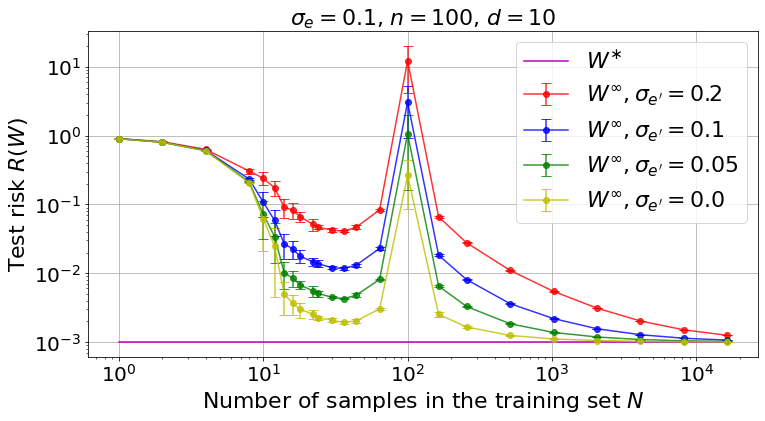

In [38]:
fontsize = 22

fig = plt.figure(figsize=(12,6))
al=0.8
ax = fig.add_subplot(111)
#ax.errorbar(train_size, GDconv_est_M, yerr=GDconv_est_S, color='g', fmt="-o",alpha=al,label=r"$W^{\infty}$", capsize=5)

ax.errorbar(train_size, GDconv_est_M[0], yerr=GDconv_est_S[0], color='r', fmt="-o",alpha=al,label=r"$W^{\infty},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[0]), capsize=5)
ax.errorbar(train_size, GDconv_est_M[1], yerr=GDconv_est_S[1], color='b', fmt="-o",alpha=al,label=r"$W^{\infty},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[1]), capsize=5)
ax.errorbar(train_size, GDconv_est_M[2], yerr=GDconv_est_S[2], color='g', fmt="-o",alpha=al,label=r"$W^{\infty},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[2]), capsize=5)
ax.errorbar(train_size, GDconv_est_M[3], yerr=GDconv_est_S[3], color='y', fmt="-o",alpha=al,label=r"$W^{\infty},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[3]), capsize=5)
ax.plot(train_size, opt_est_M,color='m', label=r"$W^{\ast}$")



ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('$\sigma_e=${}, $n=${}, $d=${}'.format(sigma_e,n,d), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est_M[0]*0.9,2.04])

plt.grid()
plt.show()


## Early stopped performances for all target noise levels

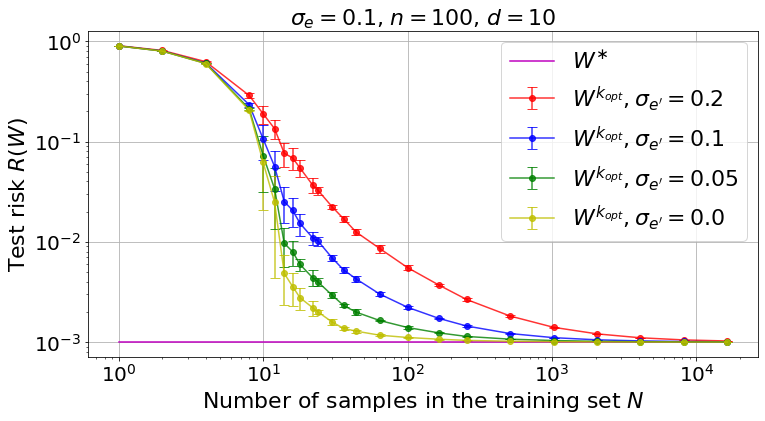

In [39]:
fontsize = 22

fig = plt.figure(figsize=(12,6))
al=0.8
ax = fig.add_subplot(111)
#ax.errorbar(train_size, GDconv_est_M, yerr=GDconv_est_S, color='g', fmt="-o",alpha=al,label=r"$W^{\infty}$", capsize=5)

ax.errorbar(train_size, learn_results_ES_M[0], yerr=learn_results_ES_S[0], color='r', fmt="-o",alpha=al,label=r"$W^{k_{opt}},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[0]), capsize=5)
ax.errorbar(train_size, learn_results_ES_M[1], yerr=learn_results_ES_S[1], color='b', fmt="-o",alpha=al,label=r"$W^{k_{opt}},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[1]), capsize=5)
ax.errorbar(train_size, learn_results_ES_M[2], yerr=learn_results_ES_S[2], color='g', fmt="-o",alpha=al,label=r"$W^{k_{opt}},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[2]), capsize=5)
ax.errorbar(train_size, learn_results_ES_M[3], yerr=learn_results_ES_S[3], color='y', fmt="-o",alpha=al,label=r"$W^{k_{opt}},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[3]), capsize=5)
ax.plot(train_size, opt_est_M,color='m', label=r"$W^{\ast}$")



ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('$\sigma_e=${}, $n=${}, $d=${}'.format(sigma_e,n,d), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est_M[0]*0.9,2.04])

plt.grid()
plt.show()


## Early stopped performances for all target noise levels but subtract the optimal performance

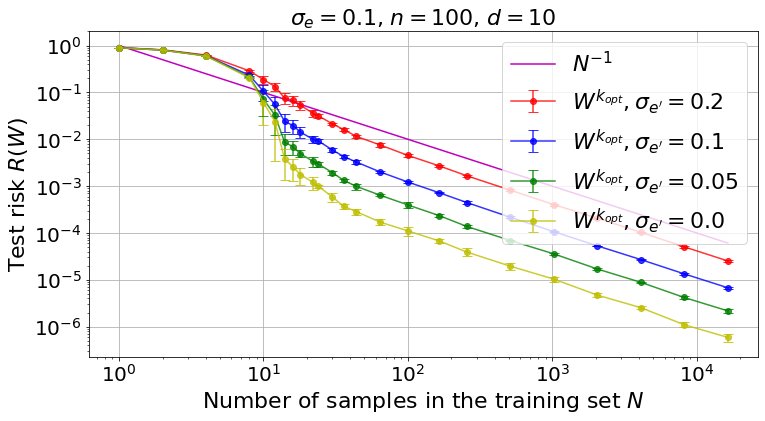

In [40]:
fontsize = 22

fig = plt.figure(figsize=(12,6))
al=0.8
ax = fig.add_subplot(111)
#ax.errorbar(train_size, GDconv_est_M, yerr=GDconv_est_S, color='g', fmt="-o",alpha=al,label=r"$W^{\infty}$", capsize=5)

ax.errorbar(train_size, learn_results_ES_MinusOpt_M[0], yerr=learn_results_ES_MinusOpt_S[0], color='r', fmt="-o",alpha=al,label=r"$W^{k_{opt}},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[0]), capsize=5)
ax.errorbar(train_size, learn_results_ES_MinusOpt_M[1], yerr=learn_results_ES_MinusOpt_S[1], color='b', fmt="-o",alpha=al,label=r"$W^{k_{opt}},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[1]), capsize=5)
ax.errorbar(train_size, learn_results_ES_MinusOpt_M[2], yerr=learn_results_ES_MinusOpt_S[2], color='g', fmt="-o",alpha=al,label=r"$W^{k_{opt}},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[2]), capsize=5)
ax.errorbar(train_size, learn_results_ES_MinusOpt_M[3], yerr=learn_results_ES_MinusOpt_S[3], color='y', fmt="-o",alpha=al,label=r"$W^{k_{opt}},\sigma_{e^\prime}=$"+"{}".format(sigma_e_prime_list[3]), capsize=5)
ax.plot(train_size, 1/np.array(train_size),color='m', label=r"$N^{-1}$")



ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('$\sigma_e=${}, $n=${}, $d=${}'.format(sigma_e,n,d), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([opt_est_M[0]*0.9,2.04])

plt.grid()
plt.show()
